# Run if on Google Colab

In [ ]:
%pip install git+https://github.com/deepmind/dm-haiku
%pip install jaxopt
%pip install optax

In [ ]:
# Set-up google drive
from google.colab import drive
drive.mount('/content/drive')

# Set up Environment

In [1]:

# Import packages
from typing import NamedTuple, Callable, Dict, List, Tuple
import functools
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import haiku as hk
import numpy as np
import optax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from itertools import product
import pickle
from flax import struct
from mynetworks import LinearLayer, ResidualBlock, BatchNormLinearLayer
from myjaxutil import *
import os


#Set seed
SEED = 42
ZERO_CLIP_MIN = 1e-5

# Markov Exchange Economy

## Define Markov Economy Class

In [2]:
# Set Pylance to ignore jnp.ndarray errors
# pyright: reportPrivateImportUsage = none


@struct.dataclass
class UtilityFunction:
    """A class that stores a utility function for one or multiple consumers with the same utility function consumer_type.
    Attributes:
        utility_type: A string that specifies the type of utility function.        
    """
    
    utility_type: str = struct.field(pytree_node=False)
    
    import jax.numpy as jnp

    def __call__(self, consumption: jnp.ndarray, consumer_type: Dict) -> jnp.ndarray:
        """Applies the utility function to an consumption and a valuation.
        Args:
            consumption: A jnp.ndarray of shape (num_agents, num_commods) representing the consumption.
            consumer_type: A dictionary of parameters for the utility function.
        """
        
        def get_ces_utility(consumption, valuation, rho):
            # Returns utility value for CES agent
            rho = rho.reshape(-1, 1)
            return jnp.sum(jnp.power(jnp.power(consumption, rho) * valuation, (1/rho)), axis = 1).clip(ZERO_CLIP_MIN) 
    
        # Linear utility function: Perfect Substitutes
        def get_linear_utility(consumption, valuation):
            return jnp.sum(consumption*valuation, axis = 1).clip(ZERO_CLIP_MIN) 

        # Cobb-Douglas utility function
        def get_CD_utility(consumption, valuation):
            # For ease of calculation, normalize valautions
            # This does not change the preference relation that the utility function represents
            normalized_vals = valuation / jnp.sum(valuation, keepdims=True)
            return jnp.prod(jnp.power(consumption, normalized_vals), axis = 1).clip(ZERO_CLIP_MIN)
        
        # Leontief utility function: Perfect Complements
        def get_leontief_utility(consumption, valuation):
            return jnp.min(consumption / valuation, axis = 1).clip(ZERO_CLIP_MIN)

        get_utils = {"CES": get_ces_utility, "linear": get_linear_utility, "Cobb-Douglas": get_CD_utility, "Leontief": get_leontief_utility}
        
            
        return get_utils[self.utility_type](consumption, **consumer_type)
 
@struct.dataclass
class SpotMarket:
    """A class that stores the state of the spot market."""
    consumer_endow: jnp.ndarray
    consumer_type: Dict
    

@struct.dataclass
class State:
    world_state: jnp.ndarray
    spot_market: SpotMarket

    def replace_state(self, new_world_state, **new_spot_market_params):
        
        new_spot_market = self.spot_market.replace(**new_spot_market_params) # type: ignore
        new_state = self.replace(world_state = new_world_state, spot_market = new_spot_market) # type: ignore
        
        return new_state
    
    
    def replace_world_state(self, new_world_state):
        
        new_state = self.replace(world_state = new_world_state) # type: ignore
        
        return new_state
    
    def replace_spot_market(self, **new_spot_market_params):
        
        new_spot_market = self.spot_market.replace(new_spot_market_params) # type: ignore
        new_state = self.replace(spot_market = new_spot_market) # type: ignore
        
        return new_state
    

@struct.dataclass
class MarkovEconomy:
    """A class that stores the parameters of a Markov Economy.
    Attributes:
        num_consumers: An integer representing the number of consumers in the economy.
        num_commods: An integer representing the number of goods in the economy.
        num_assets: An integer representing the number of assets in the economy.
        num_world_states: An integer representing the number of world states in the economy.
        util: A utility function for the consumers in the economy.
        asset_return_list: A jnp.ndarray representing the returns of the assets in each world state.
        transition_function: A function that takes the current state, consumption and portfolio and returns the next state.
        discount: A float representing the discount factor.
        init_state_function: A function that returns the initial state of the economy.
    """
    num_consumers: int 
    num_commods: int
    num_assets: int
    num_world_states: int
    util: UtilityFunction = struct.field(pytree_node=False)
    asset_return: jnp.ndarray
    transition_function: Callable[["MarkovEconomy", State, jnp.ndarray, jnp.ndarray], State] = struct.field(pytree_node=False)
    discount: float
    init_state_function: Callable[["MarkovEconomy"], State] = struct.field(pytree_node=False)
    consumer_endow_range: Tuple[float, float]
    consumer_type_range: Tuple[float, float]
    asset_return_range: Tuple[float, float]
    commod_price_space_sum: float
    asset_price_range: Tuple[float, float]
    portfolio_range: Tuple[float, float]
    
    
    def get_next_state(self, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
        
        new_state = self.transition_function(self, state, consumption, portfolio)
        
        # Observe new world state and spot market
        new_world_state = new_state.world_state
        new_spot_market = new_state.spot_market
        
        # Calculate asset payouts
        asset_payout = portfolio @ self.asset_return[new_world_state] 
        
        # Update Spot Market State
        new_types = new_spot_market.consumer_type
        new_consendow = new_spot_market.consumer_endow + asset_payout
        
        next_state = state.replace_state(new_world_state, consumer_endow = new_consendow, consumer_type = new_types)
            
        return next_state
    
    def get_initial_state(self) -> State:
        return self.init_state_function(self)
    
@struct.dataclass
class Policy:
    """A class that stores network and parameters for a policy, and applies the policy to a state.
    Attributes:
        network: A Haiku network.
        params: The parameters of the network.
    """

    network: hk.Transformed = struct.field(pytree_node=False)
    params: hk.Params

    def __call__(self, state: State, *args) -> jnp.ndarray:
        """Applies the policy to a state.
        Args:
            state: A state of the economy.
        Returns:
            The output of the network for the given state.
        """
        return self.network.apply(self.params, state, *args)
    
@struct.dataclass
class Episode:
    """A trajectory storage.
    Attributes:
        states: States of the trajectory
        actions: Actions of the trajectory
        rewards: Rewards of the trajectory
    """

    state: State
    commod_price: jnp.ndarray
    asset_price: jnp.ndarray
    consumption: jnp.ndarray
    portfolio: jnp.ndarray
    rewards: jnp.ndarray = struct.field(default_factory=jnp.ndarray)

    def get_transition(self, t):
        """Gets the SA(B)R tuple at time t.
        Args:
            t: The time step.
        Returns:
            The transition at time t.
        """
        return jax.tree_util.tree_map(lambda x: x[t], self)
    

## Build the Economy Simulator

In [33]:
# Set Pylance to ignore jnp.ndarray errors
# pyright: reportPrivateImportUsage = none

class EconomySimulator:

    @staticmethod
    def get_consumer_rewards(economy: MarkovEconomy, state: State, consumption: jnp.ndarray) -> jnp.ndarray:
        """A function that takes the consumption and returns the rewards of the consumers.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            
        Returns:
            The rewards of the consumers.
        """
        spot_market = state.spot_market
        consumer_type = spot_market.consumer_type
        
        return economy.util(consumption, consumer_type)
    
    @staticmethod
    def get_seller_reward(state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> jnp.ndarray:
        """ A function that takes the commodity and asset prices and returns the reward of the seller.
        Args:
            economy: A MarkovEconomy object.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            
        Returns:
            The reward of the seller. 
        """
        
        spot_market = state.spot_market
        consumer_endow = spot_market.consumer_endow
        consumer_type = spot_market.consumer_type
        
        excess_commod_demand = jnp.sum(consumption, axis = 0) - jnp.sum(consumer_endow, axis = 0)
        excess_asset_demand = jnp.sum(portfolio, axis = 0)
        
        return commod_price.T @ excess_commod_demand  + asset_price.T @ excess_asset_demand
        
        
        
    @staticmethod
    # @functools.partial(jax.jit, static_argnames=["util"])
    def get_rewards(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> jnp.ndarray:
        """A function that takes the current state, consumption and portfolio and returns the rewards.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            
        Returns:
            The rewards of the of the consumers and seller.
        """
        
        consumer_rewards = EconomySimulator.get_consumer_rewards(economy, state, consumption)
        seller_reward = EconomySimulator.get_seller_reward(state, commod_price, asset_price, consumption, portfolio)
        rewards = jnp.concatenate([consumer_rewards, seller_reward[..., jnp.newaxis]], axis = 0)
        
        return rewards

    @staticmethod
    # @functools.partial(jax.jit, static_argnames=["util"])
    def step(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
        """A function that takes the current state, consumption and portfolio and returns the next state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
        
        Returns:
            The next state of the economy.
        """
        
        next_state = economy.get_next_state(state, consumption, portfolio)

        return next_state

    
    @staticmethod
    # @functools.partial(jax.jit, static_argnames=["util"])
    def get_rewards_and_step(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> Tuple[jnp.ndarray, State]:
        """A function that takes the current state, consumption and portfolio and returns the rewards and next state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of each commodity.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of each asset.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            
        Returns:
            The rewards of the of the consumers and seller and the next state of the economy.
        """
        rewards = EconomySimulator.get_rewards(economy, state, commod_price, asset_price, consumption, portfolio)
        next_state = EconomySimulator.step(economy, state, consumption, portfolio)

        return (rewards, next_state)
    

    @staticmethod
    # @functools.partial(jax.jit, static_argnames=["util", "price_policy", "buyer_policy", "num_episodes"])
    def sample_state_value(economy: MarkovEconomy, state: State, policy_profile, num_episodes: int) -> jnp.ndarray:
        discount = economy.discount
        init_cumul_rewards = jnp.repeat(0.0, repeats = economy.num_consumers + 1)
        init_state = state
        init_val  = (init_cumul_rewards, init_state)
        
        def episode_step(episode_num, episode_state):
            cumul_rewards, state = episode_state
            commod_price, asset_price, consumption, portfolio = policy_profile(state)
            reward, next_state = EconomySimulator.get_rewards_and_step(economy, state, commod_price, asset_price, consumption, portfolio)
            cumul_rewards = reward + discount*cumul_rewards
            
            return (cumul_rewards, next_state)
        
        cumul_rewards, state = jax.lax.fori_loop(0, num_episodes, episode_step, init_val)
        
        return cumul_rewards
  
    @staticmethod
    def sample_trajectory(economy: MarkovEconomy, policy_profile, num_episodes: int) -> jnp.ndarray:
        discount = economy.discount
        init_state = economy.get_initial_state()

        def episode_step(state, traj):
            commod_price, asset_price, consumption, portfolio = policy_profile(state)
            next_state = EconomySimulator.step(economy, state, consumption, portfolio)
            
            # Return next state and transition
            episode = Episode(state, commod_price, asset_price, consumption, portfolio)
            return next_state, episode
        
        # Get trajectory
        final_state, trajectory = jax.lax.scan(episode_step, init_state, None, length = num_episodes)
        
        return trajectory
    
    @staticmethod
    def sample_trajectory_and_payoff(economy: MarkovEconomy, policy_profile, num_episodes: int) -> jnp.ndarray:
        discount = economy.discount
        init_state = economy.get_initial_state()
        
        def episode_step(episode_num, episode_state):
            cumul_rewards, trajectory, state = episode_state
            commod_price, asset_price, consumption, portfolio = policy_profile(state)
            reward, next_state = EconomySimulator.get_rewards_and_step(economy, state, commod_price, asset_price, consumption, portfolio)
            cumul_rewards = reward + discount*cumul_rewards
            trajectory += Episode(state, commod_price, asset_price, consumption, portfolio, reward)
            
            return (cumul_rewards, trajectory, next_state)
        
        cumul_rewards, state = jax.lax.fori_loop(0, num_episodes, episode_step, (0.0, [], init_state))
        
        return cumul_rewards
   
    @staticmethod
    def estimate_state_value(economy: MarkovEconomy, state: State, policy_profile, num_samples: int, num_episodes: int) -> jnp.ndarray:
        """Returns an estimate of the state value function from a batch of state value samples at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            policy_profile: A function that takes a state and returns the policy.
            num_samples: An integer representing the number of samples of state value samples to draw.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            An estimate of the state value function at the given state.
        """
        num_samples_list = jnp.arange(num_samples)
        enumerated_sample_state_value = lambda i: EconomySimulator.sample_state_value(economy, state, policy_profile, num_episodes)
        state_value_estimate = jnp.mean(jax.vmap(enumerated_sample_state_value)(num_samples_list), axis = 0)

        return state_value_estimate
    
    @staticmethod
    def sample_expected_future_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_episodes: int) -> jnp.ndarray:
        next_state = EconomySimulator.step(economy, state, consumption, portfolio)
        state_value_sample = EconomySimulator.sample_state_value(economy, next_state, policy_profile, num_episodes)
        
        return state_value_sample
    
    @staticmethod
    def estimate_expected_future_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_samples: int, num_episodes: int) -> jnp.ndarray:
        """Returns an estimate of the expected future value function from a batch of expected future value samples at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            policy_profile: A function that takes a state and returns the policy.
            num_samples: An integer representing the number of samples of expected future value samples to take.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            An estimate of the expected future value function at the given state.
        """
        num_samples_list = jnp.arange(num_samples)
        enumerated_sample_state_value = lambda i: EconomySimulator.sample_expected_future_value(economy, state, commod_price, asset_price, consumption, portfolio, policy_profile, num_episodes)
        state_value_estimate = jnp.mean(jax.vmap(enumerated_sample_state_value)(num_samples_list), axis = 0)

        return state_value_estimate


    @staticmethod
    def sample_action_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_episodes: int) -> jnp.ndarray:
        """Returns a sample of the action value function at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            policy_profile: A function that takes a state and returns the policy.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            A sample of the action value function at the given state.
        """
        discount = economy.discount
        
        rewards, next_state = EconomySimulator.get_rewards_and_step(economy, state, commod_price, asset_price, consumption, portfolio)
        state_value_sample = EconomySimulator.sample_state_value(economy, next_state, policy_profile, num_episodes)
        action_value_sample = rewards + discount*state_value_sample

        return action_value_sample
    
    @staticmethod
    def estimate_action_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_samples: int, num_episodes: int) -> jnp.ndarray:
        """Returns an estimate of the action value function from a batch of action value samples at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            policy_profile: A function that takes a state and returns the policy.
            num_samples: An integer representing the number of samples of action value samples to take.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            An estimate of the action value function at the given state.
        """
        num_samples_list = jnp.arange(num_samples)
        enumerated_sample_state_value = lambda i: EconomySimulator.sample_action_value(economy, state, commod_price, asset_price, consumption, portfolio, policy_profile, num_episodes)
        action_value_sample = jnp.mean(jax.vmap(enumerated_sample_state_value)(num_samples_list), axis = 0)

        return action_value_sample        



    @staticmethod
    # @functools.partial(jax.jit, static_argnames=["util", "num_episodes"])
    def estimate_payoff(economy: MarkovEconomy, policy_profile, num_samples, num_episodes: int):
        init_state_samples = EconomySimulator.sample_state(economy, num_samples)
        
        enumerated_sample_state_value = lambda s: EconomySimulator.sample_state_value(economy, s, policy_profile, num_episodes)
        state_value_sample = jnp.mean(jax.vmap(enumerated_sample_state_value)(init_state_samples), axis = 0)

        return state_value_sample
 
    @staticmethod
    def estimate_state_cumulative_regret(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], br_policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int):
        num_consumers = economy.num_consumers
        
        consumers_br_seller_policy_profile = lambda s: policy_profile(s)[:2] + br_policy_profile(s)[2:]
        seller_br_consumers_policy_profile = lambda s: br_policy_profile(s)[:2] +  policy_profile(s)[2:]
        
        consumers_br_payoff = EconomySimulator.estimate_state_value(economy, state, consumers_br_seller_policy_profile, num_samples, num_episodes)[:num_consumers]
        sellers_br_payoff = EconomySimulator.estimate_state_value(economy, state, seller_br_consumers_policy_profile, num_samples, num_episodes)[num_consumers:]
        
        payoff = EconomySimulator.estimate_state_value(economy, state, policy_profile, num_samples, num_episodes)
        consumers_payoff = payoff[:num_consumers]
        sellers_payoff = payoff[num_consumers:]
        
        consumers_cumul_regret = jnp.sum(consumers_br_payoff - consumers_payoff).squeeze()
        seller_cumul_regret = (sellers_br_payoff - sellers_payoff).squeeze()
        
        return consumers_cumul_regret + seller_cumul_regret
    
    @staticmethod
    def estimate_cumulative_regret(economy: MarkovEconomy, policy_profile: Callable[[State], Tuple], br_policy_profile: Callable[[State], Tuple], num_samples:int, num_episodes: int):
        num_consumers = economy.num_consumers
        
        consumers_br_seller_policy_profile = lambda s: policy_profile(s)[:2] + br_policy_profile(s)[2:]
        seller_br_consumers_policy_profile = lambda s: br_policy_profile(s)[:2] +  policy_profile(s)[2:]
        
        consumers_br_payoff = EconomySimulator.estimate_payoff(economy, consumers_br_seller_policy_profile, num_samples, num_episodes)[:num_consumers]
        sellers_br_payoff = EconomySimulator.estimate_payoff(economy, seller_br_consumers_policy_profile, num_samples, num_episodes)[num_consumers:] 
        
        payoff = EconomySimulator.estimate_payoff(economy, policy_profile, num_samples, num_episodes)
        
        consumers_payoff = payoff[:num_consumers]
        sellers_payoff = payoff[num_consumers:]
        
        consumers_cumul_regret = jnp.sum(consumers_br_payoff - consumers_payoff).squeeze()
        seller_cumul_regret = (sellers_br_payoff - sellers_payoff).squeeze()
        
        return consumers_cumul_regret + seller_cumul_regret

    ############### Market Statistic Functions ##################
    
    @staticmethod
    def get_state_excess_demand(state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """A function that takes the current state, consumption and portfolio and returns the excess demand of the goods and assets.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
        Returns:
            The excess demand of the goods and assets.
        """
        spot_market = state.spot_market
        consumer_endow = spot_market.consumer_endow
        excess_commod_demand = jnp.sum(consumption, axis = 0) - jnp.sum(consumer_endow, axis = 0)
        excess_asset_demand = jnp.sum(portfolio, axis = 0)
        
        return (excess_commod_demand, excess_asset_demand)
    
    @staticmethod
    def get_excess_spendings(state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> jnp.ndarray:
        """A function that takes the current state, consumption and portfolio and returns the excess spending of the consumers.
        Args:
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
        Returns:
            The excess spending of the consumers.
        """
        spot_market = state.spot_market
        consumer_endow = spot_market.consumer_endow
        
        excess_spendings =  consumer_endow @ commod_price +  portfolio @ asset_price
        
        return excess_spendings
    
   
    @staticmethod
    def estimate_state_best_response_and_value(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        """ Estimate the best response commodity prices, asset prices, consumptions, and portfolio to a given policy at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            policy_profile: A function that takes a state and returns the policy.
            num_samples: An integer representing the number of samples of action value samples to take.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            The best responses the given policy and associated best-response state-values at the given state.
        """
        num_commods = economy.num_commods
        num_assets = economy.num_assets
        consumer_endow_max = economy.consumer_endow_range[1]
        price_space_sum = economy.commod_price_space_sum
        
        commod_price, asset_price, consumption, portfolio = policy_profile(state)

        excess_commod_demand, excess_asset_demand = EconomySimulator.get_state_excess_demand(state, consumption, portfolio)
        
        br_commod_price = jax.nn.one_hot(jnp.argmax(excess_commod_demand), num_commods)*price_space_sum
        br_asset_price = jnp.clip(excess_asset_demand, a_min= 0.0, a_max = 1.0)*consumer_endow_max
        
        br_seller_state_value = EconomySimulator.estimate_action_value(economy, state, br_commod_price, br_asset_price, consumption, portfolio, policy_profile, num_samples, num_episodes)[-1]

        # Get best response consumption and portfolio
        br_action_value_function = lambda action: EconomySimulator.estimate_action_value(economy, state, commod_price, asset_price, action[0], action[1], policy_profile, num_samples, num_episodes)
        
        br_consumer_state_value, (br_consumption, br_portfolio) = maximize(br_action_value_function, (consumption, portfolio), proj=lambda x: x)
        
        br_state_value = jnp.concatenate([br_consumer_state_value, br_seller_state_value], axis = 0) 
        
        return br_state_value, (br_commod_price, br_asset_price, br_consumption, br_portfolio)
 
    @staticmethod
    def estimate_state_bellman_error(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        """ Compute the Bellman error of a policy at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            policy_profile: A function that takes a state and returns the policy.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            The Bellman error of the policy at the given state.
        """
        
        num_world_states = economy.num_world_states
        num_commods = economy.num_commods
        num_assets = economy.num_assets
        num_consumers = economy.num_consumers
        consendow_range = economy.consumer_endow_range
        type_endow_range = economy.consumer_type_range
        
        
        policy_state_value = EconomySimulator.estimate_state_value(economy, state, policy_profile, num_samples, num_episodes)
    
        br_state_value = EconomySimulator.estimate_state_best_response_and_value(economy, state, policy_profile, num_samples, num_episodes)[0]
        
        bellman_error = jnp.mean(jnp.square(policy_state_value - br_state_value))
        
        return  bellman_error
    
    @staticmethod    
    def sample_state(economy: MarkovEconomy, num_samples):
        num_world_states = economy.num_world_states
        num_commods = economy.num_commods
        num_assets = economy.num_assets
        num_consumers = economy.num_consumers
        consendow_range = economy.consumer_endow_range
        type_endow_range = economy.consumer_type_range
        
        world_states_samples = jax.random.randint(jax.random.PRNGKey(0), shape = (num_samples,), minval = 0, maxval = num_world_states)
        consumer_endow_samples = jax.random.uniform(jax.random.PRNGKey(0), shape = (num_samples, num_consumers, num_commods), minval = consendow_range[0], maxval = consendow_range[1])
        consumer_type_samples = jax.random.uniform(jax.random.PRNGKey(0), shape = (num_samples, num_consumers, num_commods), minval = type_endow_range[0], maxval = type_endow_range[1])
        state_samples = jax.vmap(lambda o, e, t: State(o, SpotMarket(e, {"valuation": t})), in_axes = 0)(world_states_samples, consumer_endow_samples, consumer_type_samples)
        # state_samples = [State(o, SpotMarket(e, t)) for (o, e, t) in zip(world_states_samples, consumer_endow_samples, consumer_type_samples)]
        return state_samples
    
    @staticmethod
    def estimate_bellman_error(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        """ Compute the Bellman error of a policy at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            policy_profile: A function that takes a state and returns the policy.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            The Bellman error of the policy at the given state.
        """
        
        state_samples = EconomySimulator.sample_state(economy, num_samples)
        
        bellman_error_samples = jax.vmap(lambda s: EconomySimulator.estimate_state_bellman_error(economy, s, policy_profile, num_samples, num_episodes))(state_samples)
        
        bellman_error_estimate = jnp.mean(bellman_error_samples)
        
        return  bellman_error_estimate
    
    @staticmethod
    # @functools.partial(jax.jit, static_argnames=[ "policy_profile"])
    def seller_first_order_state_violation(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple]):
        price_space_sum = economy.commod_price_space_sum
        commod_price, asset_price, consumption, portfolio = policy_profile(state)
        excess_commod_demand, excess_asset_demand = EconomySimulator.get_state_excess_demand(state, consumption, portfolio)
        asset_price_feasibility = jnp.sum(asset_price) - price_space_sum
        return jnp.mean(jnp.square(excess_commod_demand)) + jnp.mean(jnp.square(excess_asset_demand))
    
    @staticmethod
    # @functools.partial(jax.jit, static_argnames=[ "policy_profile"])
    def consumers_first_order_state_violation(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        commod_price, asset_price, consumption, portfolio = policy_profile(state)
        consendow = state.spot_market.consumer_endow
        num_consumers = economy.num_consumers
        discount = economy.discount
        
        util = lambda x: economy.util(x, state.spot_market.consumer_type)
        util_value = util(consumption)
        grad_util_jac = jax.jacfwd(util)(consumption)
        grad_util = jnp.einsum("iij->ij", grad_util_jac)
        
        consumer_future_value = lambda x, y: EconomySimulator.estimate_expected_future_value(economy, state, commod_price, asset_price, x, y, policy_profile, num_samples, num_episodes)[:num_consumers]
        jac_consumption_state_value = jax.jacfwd(consumer_future_value, argnums = 0)(consumption, portfolio)
        jac_portfolio_state_value = jax.jacfwd(consumer_future_value, argnums = 1)(consumption, portfolio)
    
        grad_consumption_state_value = jnp.einsum("iij->ij", jac_consumption_state_value)
        grad_portfolio_state_value = jnp.einsum("iij->ij", jac_portfolio_state_value)
        
        bang = util_value + discount*jnp.einsum("ij,ij->i", grad_consumption_state_value, consumption) + discount*jnp.einsum("ij,ij->i", grad_portfolio_state_value, portfolio)
        bang_per_buck = bang/(consendow @ commod_price)
        
        
        consumption_first_order_violation = grad_util - jnp.einsum("i,j->ij", bang_per_buck, commod_price) + discount*grad_consumption_state_value
        portfolio_first_order_violation = - jnp.einsum("i,j->ij", bang_per_buck, asset_price) + discount*grad_portfolio_state_value
        budget_violation = consendow @ commod_price - consumption @ commod_price -  portfolio @ asset_price
        
        gradient_norms_sum = 3
        
        consumption_norm = jnp.mean(jnp.square(consumption_first_order_violation))
        portfolio_norm = jnp.mean(jnp.square(portfolio_first_order_violation))
        budget_norm = jnp.mean(jnp.square(budget_violation))
        
        return (consumption_norm + portfolio_norm + gradient_norms_sum)/gradient_norms_sum

    @staticmethod
    # @functools.partial(jax.jit, static_argnames=[ "policy_profile"])
    def first_order_state_violation(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        seller_violation = EconomySimulator.seller_first_order_state_violation(economy, state, policy_profile) 
        consumers_violation = EconomySimulator.consumers_first_order_state_violation(economy, state, policy_profile, num_samples, num_episodes, solver_params)
        return (seller_violation + consumers_violation)/2.0

    @staticmethod
    # @functools.partial(jax.jit, static_argnames=[ "policy_profile"])
    def estimate_first_order_seller_violation(economy: MarkovEconomy,policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        state_samples = EconomySimulator.sample_state(economy, num_samples)
        violation_samples = jax.vmap(lambda s: EconomySimulator.seller_first_order_state_violation(economy, s, policy_profile) , in_axes = 0)(state_samples)
        violation_estimate = jnp.mean(violation_samples)
        return violation_estimate

    @staticmethod
    # @functools.partial(jax.jit, static_argnames=[ "policy_profile"])
    def estimate_first_order_consumer_violation(economy: MarkovEconomy,policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        state_samples = EconomySimulator.sample_state(economy, num_samples)
        violation_samples = jax.vmap(lambda s: EconomySimulator.consumers_first_order_state_violation(economy, s, policy_profile, num_samples, num_episodes, solver_params), in_axes = 0)(state_samples)
        violation_estimate = jnp.mean(violation_samples)
        return violation_estimate


    @staticmethod
    def estimate_first_order_violation(economy: MarkovEconomy,policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
        state_samples = EconomySimulator.sample_state(economy, num_samples)
        violation_samples = jax.vmap(lambda s: EconomySimulator.first_order_state_violation(economy, s, policy_profile, num_samples, num_episodes, solver_params), in_axes = 0)(state_samples)
        violation_estimate = jnp.mean(violation_samples)
        return violation_estimate
    
    

## Policy Networks

In [34]:

def _eqm_network(state: State, economy: MarkovEconomy):
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    world_state = state.world_state
    asset_return = economy.asset_return[world_state]
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    consumer_endow_min = economy.consumer_endow_range[0]
    consumer_endow_max = economy.consumer_endow_range[1]
    
    discount = economy.discount
    
    commod_price_space_sum = economy.commod_price_space_sum
    asset_price_range = economy.asset_price_range
    portfolio_range = economy.portfolio_range
    
    aggregate_supply = jnp.sum(consumer_endow, axis = 0)
    
    consumer_type_latent = LinearLayer(100, jax.nn.relu)(jnp.concatenate(list(consumer_type.values()), axis = -1))

    consumer_endow_latent = LinearLayer(100, jax.nn.relu)(consumer_endow)
    
    assets_latent_flattened = jnp.concatenate([asset_return, world_state, discount], axis = None)
    consumer_assets_latent = LinearLayer(num_consumers*100, jax.nn.relu)(assets_latent_flattened).reshape(num_consumers, 100)
    
    consumer_latent = jnp.concatenate([consumer_type_latent, consumer_endow_latent, consumer_assets_latent], axis = -1)
    consumer_latent = LinearLayer(100, jax.nn.relu)(consumer_latent)
    
    price_latent = jnp.sum(consumer_latent, axis = 0)
    price_latent = LinearLayer(100, jax.nn.relu)(price_latent)
    
    commod_price_latent = LinearLayer(100, jax.nn.relu)(price_latent)
    commod_price = LinearLayer(num_commods, jax.nn.softmax)(commod_price_latent)*commod_price_space_sum 
    
    asset_price_latent = LinearLayer(100, jax.nn.relu)(price_latent)
    asset_price = LinearLayer(num_assets, jax.nn.sigmoid)(asset_price_latent)*asset_price_range[1]
    
    commod_price_tiled = jnp.tile(commod_price, [num_consumers, 1])
    asset_price_tiled = jnp.tile(asset_price, [num_consumers, 1])
    
    market_state = jnp.concatenate([consumer_latent, commod_price_tiled, asset_price_tiled], axis = -1)
    
    market_latent = LinearLayer(100, jax.nn.relu)(market_state)
    portfolio_sell = LinearLayer(num_assets, jax.nn.sigmoid)(market_latent)*portfolio_range[1]
    
    budgets = consumer_endow @ commod_price + portfolio_sell @ asset_price
    
    coefs = LinearLayer(num_commods+num_assets, jax.nn.softmax)(market_latent)

    consumption_coefs = coefs[:, :num_commods]
    portfolio_coefs = coefs[:, num_commods:]
    price_tiled = jnp.tile(jnp.concatenate([commod_price, asset_price]), [num_consumers, 1])
    
    # Project to budget simplex
    budget_matrix = jnp.tile(budgets, [num_commods+num_assets, 1]).T
    budget_simplices = budget_matrix / price_tiled.clip(min = ZERO_CLIP_MIN)
    
    budget_simplices_commods = budget_simplices[:, :num_commods]
    budget_simplices_assets = budget_simplices[:, num_commods:]
    
    consumption = consumption_coefs * budget_simplices_commods
    portfolio_buy = portfolio_coefs * budget_simplices_assets
    portfolio = portfolio_buy - portfolio_sell
    
    aggregate_demand = jnp.sum(consumption, axis = 0)
    # consumption = consumption*jnp.clip(aggregate_supply/(ZERO_CLIP_MIN+aggregate_demand), a_min = ZERO_CLIP_MIN, a_max = 1)
    # consumption = jnp.clip(consumption, a_min = ZERO_CLIP_MIN, a_max = aggregate_demand)
    return  (commod_price, asset_price, consumption, portfolio)

###########################################################################################################################################################
def _br_network(state: State, action_profile, economy: MarkovEconomy):
    # pi: s=(b, p) -> a' where a' is the budget share matrix
    commod_price, asset_price, consumption, portfolio = action_profile
    
    
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    world_state = state.world_state
    asset_return = economy.asset_return[world_state]
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    consumer_endow_min = economy.consumer_endow_range[0]
    consumer_endow_max = economy.consumer_endow_range[1]
    
    discount = economy.discount
    
    commod_price_space_sum = economy.commod_price_space_sum
    asset_price_range = economy.asset_price_range
    portfolio_range = economy.portfolio_range
    
    consumer_type_latent = LinearLayer(100, jax.nn.relu)(jnp.concatenate(list(consumer_type.values()), axis = -1))

    consumer_endow_latent = LinearLayer(100, jax.nn.relu)(consumer_endow)
    
    assets_latent_flattened = jnp.concatenate([asset_return, world_state, discount], axis = None)
    consumer_assets_latent = LinearLayer(num_consumers*100, jax.nn.relu)(assets_latent_flattened).reshape(num_consumers, 100)
    
    
    consumer_latent = jnp.concatenate([consumer_type_latent, consumer_endow_latent, consumer_assets_latent], axis = -1)
    consumer_latent = LinearLayer(100, jax.nn.relu)(consumer_latent)
    
    
    commod_price_tiled = jnp.tile(commod_price, [num_consumers, 1])
    asset_price_tiled = jnp.tile(asset_price, [num_consumers, 1])
    market_state = jnp.concatenate([consumer_latent, commod_price_tiled, asset_price_tiled], axis = -1)
    
    market_latent = LinearLayer(100, jax.nn.relu)(market_state)
    portfolio_sell = LinearLayer(num_assets, jax.nn.sigmoid)(market_latent)*portfolio_range[1]
    
    budgets = consumer_endow @ commod_price + portfolio_sell @ asset_price

    coefs = LinearLayer(num_commods+num_assets, jax.nn.softmax)(market_latent)
    
    consumption_coefs = coefs[:, :num_commods]
    portfolio_coefs = coefs[:, num_commods:]
    price_tiled = jnp.tile(jnp.concatenate([commod_price, asset_price]), [num_consumers, 1])
    
    # Project to budget simplex
    budget_matrix = jnp.tile(budgets, [num_commods+num_assets, 1]).T
    budget_simplices = budget_matrix / price_tiled.clip(min = ZERO_CLIP_MIN)
    
    budget_simplices_commods = budget_simplices[:, :num_commods]
    budget_simplices_assets = budget_simplices[:, num_commods:]
    
    br_consumption = consumption_coefs * budget_simplices_commods
    portfolio_buy = portfolio_coefs * budget_simplices_assets
    br_portfolio = portfolio_buy - portfolio_sell
    
    
    ######### Best-Response Prices #########
    excess_commod_demand = jnp.sum(consumption, axis = 0) - jnp.sum(consumer_endow, axis = 0)
    excess_asset_demand = jnp.sum(portfolio, axis = 0)
    
    br_commod_price = jax.nn.softmax(excess_commod_demand)*commod_price_space_sum
    br_asset_price = jax.nn.sigmoid(excess_asset_demand)*asset_price_range[1]
    
    return  (br_commod_price, br_asset_price, br_consumption, br_portfolio)


# Solution Methods

## Exploitability Minimization

In [109]:
def exploitability_minimization(economy: MarkovEconomy, eqm_network_lr: float, br_network_lr: float, num_epochs: int, num_samples: int, num_episodes:int):
    """ Training Procedure. """
    cumul_regrets = []
    avg_excess_demands = []
    consumer_first_order_violations = []
    total_first_order_violations = []
    prng = hk.PRNGSequence(SEED)

    # Initialize eqm network
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy.get_initial_state(), economy)
    
    
    # Initialize Optimizer for eqm network
    eqm_optimizer, eqm_opt_state = init_optimiser(eqm_network_lr, eqm_params)
    
    
    # Initialize best-response network
    br_network = hk.without_apply_rng(hk.transform(_br_network))
    br_params = br_network.init(next(prng), economy.get_initial_state(), eqm_network.apply(
                eqm_params, economy.get_initial_state(), economy), economy)
    
    
    # Initialize Optimizer for best-response network
    br_optimizer, br_opt_state = init_optimiser(br_network_lr, br_params)
    
    
    @jax.jit
    def cumulative_neural_loss(eqm_params:  hk.Params, br_params:  hk.Params):
        eqm_generator = Policy(eqm_network, eqm_params)
        br_discriminator = Policy(br_network, br_params)
        
        eqm_policy = lambda s: eqm_generator(s, economy) # type: ignore
        br_policy = lambda s: br_discriminator(s, eqm_generator(s, economy), economy) #type: ignore
        
        # consumers_br_seller_policy_profile = lambda s: policy_profile(s, economy)[:2] + br_policy_profile(s, policy_profile(s, economy), economy)[2:]
        # seller_br_consumers_policy_profile = lambda s: br_policy_profile(s, policy_profile(s, economy), economy)[:2] +  policy_profile(s, economy)[2:]
        
        return EconomySimulator.estimate_cumulative_regret(economy, eqm_policy, br_policy, num_samples, num_episodes) # type: ignore
        

    @jax.jit
    def get_grads(eqm_params:  hk.Params, br_params:  hk.Params):
        cumul_regret, (eqm_network_grad, br_network_grad) = jax.value_and_grad(cumulative_neural_loss, argnums=[0, 1])(eqm_params, br_params)
        return cumul_regret, eqm_network_grad, br_network_grad

    @jax.jit
    def update_params(eqm_params, br_params, eqm_opt_state, br_opt_state):
        cumul_regret, eqm_network_grad, br_network_grad = get_grads(eqm_params, br_params)
        
        # Eqm Network Update
        eqm_updates, eqm_opt_state = eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)
        
        # Br Network Update
        br_network_grad = jax.tree_util.tree_map(lambda x: -x, br_network_grad)
        br_updates, br_opt_state = br_optimizer(br_network_grad, br_opt_state, br_params)
        br_params = optax.apply_updates(br_params, br_updates)

        return cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state)


    for epoch in range(num_epochs):
        print(f"==================== Epoch {epoch} ====================")
        cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state) = update_params(eqm_params, br_params, eqm_opt_state, br_opt_state)
        
        # avg_excess_demand, bang_per_buck_diff = evaluate(prices_actor, buyer_actor, market_params, utils)
        if epoch % 1 == 0:
        
            eqm_generator = Policy(eqm_network, eqm_params)
            eqm_policy = lambda s: eqm_generator(s, economy)
            # excess_demand_violation = EconomySimulator.estimate_first_order_seller_violation(economy, eqm_policy, num_samples, num_episodes) # type: ignore
            # consumer_first_order_violation = EconomySimulator.estimate_first_order_consumer_violation(economy, eqm_policy, num_samples, num_episodes) # type: ignore
            
            total_first_order_loss = EconomySimulator.estimate_first_order_violation(economy, eqm_policy, num_samples, num_episodes) #type: ignore
            print(f"Cumulative Regret: {cumul_regret}")
            print(f"Total First Order Violation: {total_first_order_loss}")
            # print(f"Average excess demand: {excess_demand_violation}")
            # print(f"Consumer first order violation: {consumer_first_order_violation}")

            total_first_order_violations.append(total_first_order_loss)
            cumul_regrets.append(cumul_regret)
            # avg_excess_demands.append(excess_demand_violation)
            # consumer_first_order_violations.append(consumer_first_order_violation)
        
    # return (cumul_regrets, avg_excess_demands, consumer_first_order_violations), prices_actor, buyer_actor
    
    eqm_policy = Policy(eqm_network, eqm_params)
    br_policy = Policy(br_network, br_params)
        
    return (cumul_regrets, total_first_order_violations, avg_excess_demands, consumer_first_order_violations), eqm_policy, br_policy

## Neural Projection Method

In [36]:
def neural_projection_method(economy: MarkovEconomy, eqm_network_lr: float, num_epochs: int, num_samples: int, num_episodes:int):
    """ Training Procedure. """
    losses = []
    avg_excess_demands = []
    bang_per_buck_diffs = []
    prng = hk.PRNGSequence(SEED)

    # Initialize eqm network
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy.get_initial_state(), economy)
    
    
    # Initialize Optimizer for eqm network
    eqm_optimizer, eqm_opt_state = init_optimiser(eqm_network_lr, eqm_params)
    
    
    @jax.jit
    def neural_loss(eqm_params:  hk.Params):
        eqm_generator = Policy(eqm_network, eqm_params)
        eqm_policy = lambda s: eqm_generator(s, economy) # type: ignore
        
        return EconomySimulator.estimate_first_order_violation(economy, eqm_policy, num_samples, num_episodes) # type: ignore
        

    @jax.jit
    def get_grads(eqm_params:  hk.Params):
        loss, eqm_network_grad = jax.value_and_grad(neural_loss)(eqm_params)
        return loss, eqm_network_grad

    @jax.jit
    def update_params(eqm_params, eqm_opt_state):
        loss, eqm_network_grad = get_grads(eqm_params)
        
        # Eqm Network Update
        eqm_updates, eqm_opt_state = eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)
        
        return loss, eqm_params, eqm_opt_state

    for epoch in range(num_epochs):
        print(f"==================== Epoch {epoch} ====================")
        loss, eqm_params, eqm_opt_state = update_params(eqm_params, eqm_opt_state)
        
        
        # avg_excess_demand, bang_per_buck_diff = evaluate(prices_actor, buyer_actor, market_params, utils)
        print(f"First-Order Loss: {loss}")
        # print(f"Average excess demand: {avg_excess_demand})
        # print(f"Average excess demand: {avg_excess_demand}, Bang per buck difference: {bang_per_buck_diff}")
        # avg_excess_demands.append(avg_excess_demand)
        # bang_per_buck_diffs.append(bang_per_buck_diff)
        losses.append(loss)
    # return (losss, avg_excess_demands, bang_per_buck_diffs), prices_actor, buyer_actor
    
    eqm_policy = Policy(eqm_network, eqm_params)
        
    return losses, eqm_policy

## DeepHAM

In [7]:
def deep_ham(economy: MarkovEconomy, eqm_network_lr: float, num_epochs: int, num_br_epochs: int, num_samples: int, num_episodes:int):
    """ Training Procedure. """
    losses = []
    avg_excess_demands = []
    bang_per_buck_diffs = []
    prng = hk.PRNGSequence(SEED)

    # Initialize eqm network
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy.get_initial_state(), economy)
    
    
    # Initialize Optimizer for eqm network
    eqm_optimizer, eqm_opt_state = init_optimiser(eqm_network_lr, eqm_params)
    
    
    @jax.jit
    def neural_loss(eqm_params:  hk.Params):
        eqm_generator = Policy(eqm_network, eqm_params)
        eqm_policy = lambda s: eqm_generator(s, economy) # type: ignore
        
        return EconomySimulator.estimate_cumulative_regret(economy, frozen_eqm_policy, eqm_policy, num_samples, num_episodes) # type: ignore
        
    @jax.jit
    def get_grads(eqm_params:  hk.Params):
        loss, eqm_network_grad = jax.value_and_grad(neural_loss)(eqm_params)
        return loss, eqm_network_grad

    @jax.jit
    def update_params(eqm_params, eqm_opt_state):
        loss, eqm_network_grad = get_grads(eqm_params)
        
        # Eqm Network Update
        eqm_updates, eqm_opt_state = eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)
        
        return loss, eqm_params, eqm_opt_state

    for epoch in range(num_epochs):
        print(f"==================== Epoch {epoch} ====================")
        
        frozen_eqm_network = Policy(eqm_network, eqm_params)
        frozen_eqm_policy = lambda s: jax.lax.stop_gradient(frozen_eqm_network(s, economy))
        for br_epoch in range(num_br_epochs):
            print(f"==================== Best-Response Epoch {br_epoch} ====================")
            
            cumul_regret, eqm_params, eqm_opt_state = update_params(eqm_params, eqm_opt_state)
            
            
            # avg_excess_demand, bang_per_buck_diff = evaluate(prices_actor, buyer_actor, market_params, utils)
            print(f"Cumulative Regret: {cumul_regret}")
            # print(f"Average excess demand: {avg_excess_demand})
            # print(f"Average excess demand: {avg_excess_demand}, Bang per buck difference: {bang_per_buck_diff}")
            # avg_excess_demands.append(avg_excess_demand)
            # bang_per_buck_diffs.append(bang_per_buck_diff)
            losses.append(cumul_regret)
    # return (losss, avg_excess_demands, bang_per_buck_diffs), prices_actor, buyer_actor
    
    eqm_policy = Policy(eqm_network, eqm_params)
        
    return losses, eqm_policy

## Evaluate

In [28]:
def plot_loss_dict(losses):
    num_losses = len(losses)
    num_rows = (num_losses - 1) // 3 + 1
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    for i, (name, loss) in enumerate(losses.items()):
        row = i // 3
        col = i % 3
        if num_rows == 1:
            axs[col].plot(loss)
            axs[col].set_title(name)
            continue
        axs[row, col].plot(loss)
        axs[row, col].set_title(name)
    plt.show()

# Test Algorithms

## Exploitability Minimization

### Linear Economy

#### Hyperparameter search

In [15]:
# pyright: reportPrivateImportUsage = none

# Market parameters
key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 7 
num_commods = 5
num_assets = 1
num_world_states = 4
util_type = "linear"
discount = 0.8
consumer_endow_range = (0.1*max_supply/(num_consumers*num_commods), max_supply/(num_consumers*num_commods))
consumer_type_range = (1.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)


asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods))

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    world_state = state.world_state
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    # Get next world state
    next_world_state =  0 # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    
    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])
    
    # Get next consumer types
    next_consumer_type = consumer_type 
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)    
    
    
def init_state_function(economy: MarkovEconomy) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
     
    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)
    
    # Get next consumer endowments
    init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
    init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)
    
    # Get next consumer types
    init_consumer_valuation = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }
    
    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))

util = UtilityFunction(util_type)

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)


# Initialize training parameters
eqm_lr_sweep = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
br_lr_sweep = [1e-3, 1e-4, 1e-5]


num_samples = 8
num_epochs = 100
num_episodes = 30

data_cumul_regrets_linear = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_excess_demand_linear = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_consumer_first_order_violations_linear = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}

for eqm_lr, br_lr  in product(eqm_lr_sweep, br_lr_sweep):
    print(f"==================== Eqm. lr: {eqm_lr}, Br lr: {br_lr} ====================")

    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    
    (cumul_regrets, avg_excess_demands, consumer_first_order_violations), eqm_network, br_network = exploitability_minimization(economy, eqm_lr, br_lr, num_epochs, num_samples, num_episodes)

        
    data_cumul_regrets_linear[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = cumul_regrets
    data_avg_excess_demand_linear[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = avg_excess_demands
    data_consumer_first_order_violations_linear[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = consumer_first_order_violations
    
    
# Create a folder to store the dictionaries
folder_name = "data"
os.makedirs(folder_name, exist_ok=True)

# Save the dictionaries as files inside the folder
data_cumul_regrets_linear_file = os.path.join(folder_name, "data_cumul_regrets_linear.pkl")
data_avg_excess_demand_linear_file = os.path.join(folder_name, "data_avg_excess_demand_linear.pkl")
data_consumer_first_order_violations_linear_file = os.path.join(folder_name, "data_consumer_first_order_violations_linear.pkl")

# Save the dictionaries as files
with open(data_cumul_regrets_linear_file, "wb") as f:
    pickle.dump(data_cumul_regrets_linear, f)

with open(data_avg_excess_demand_linear_file, "wb") as f:
    pickle.dump(data_avg_excess_demand_linear, f)

with open(data_consumer_first_order_violations_linear_file, "wb") as f:
    pickle.dump(data_consumer_first_order_violations_linear, f)


==================== Eqm. lr: 0.0001, Br lr: 0.001 ====================
==================== Epoch 0 ====================
Cumulative Regret: 8231.712890625
Average excess demand: 1040.958984375
Consumer first order violation: 1.462348901557101e+28
==================== Epoch 1 ====================
Cumulative Regret: 350217699328.0
Average excess demand: 1018.2890014648438
Consumer first order violation: 9.897566441664099e+33
==================== Epoch 2 ====================
Cumulative Regret: 4741847040.0
Average excess demand: 1001.5252685546875
Consumer first order violation: 1.2631068525352078e+31
==================== Epoch 3 ====================
Cumulative Regret: 106521591808.0
Average excess demand: 987.9274291992188
Consumer first order violation: 6494.8037109375
==================== Epoch 4 ====================
Cumulative Regret: 34857.6171875
Average excess demand: 976.62841796875
Consumer first order violation: 6062.43603515625
==================== Epoch 5 ====================

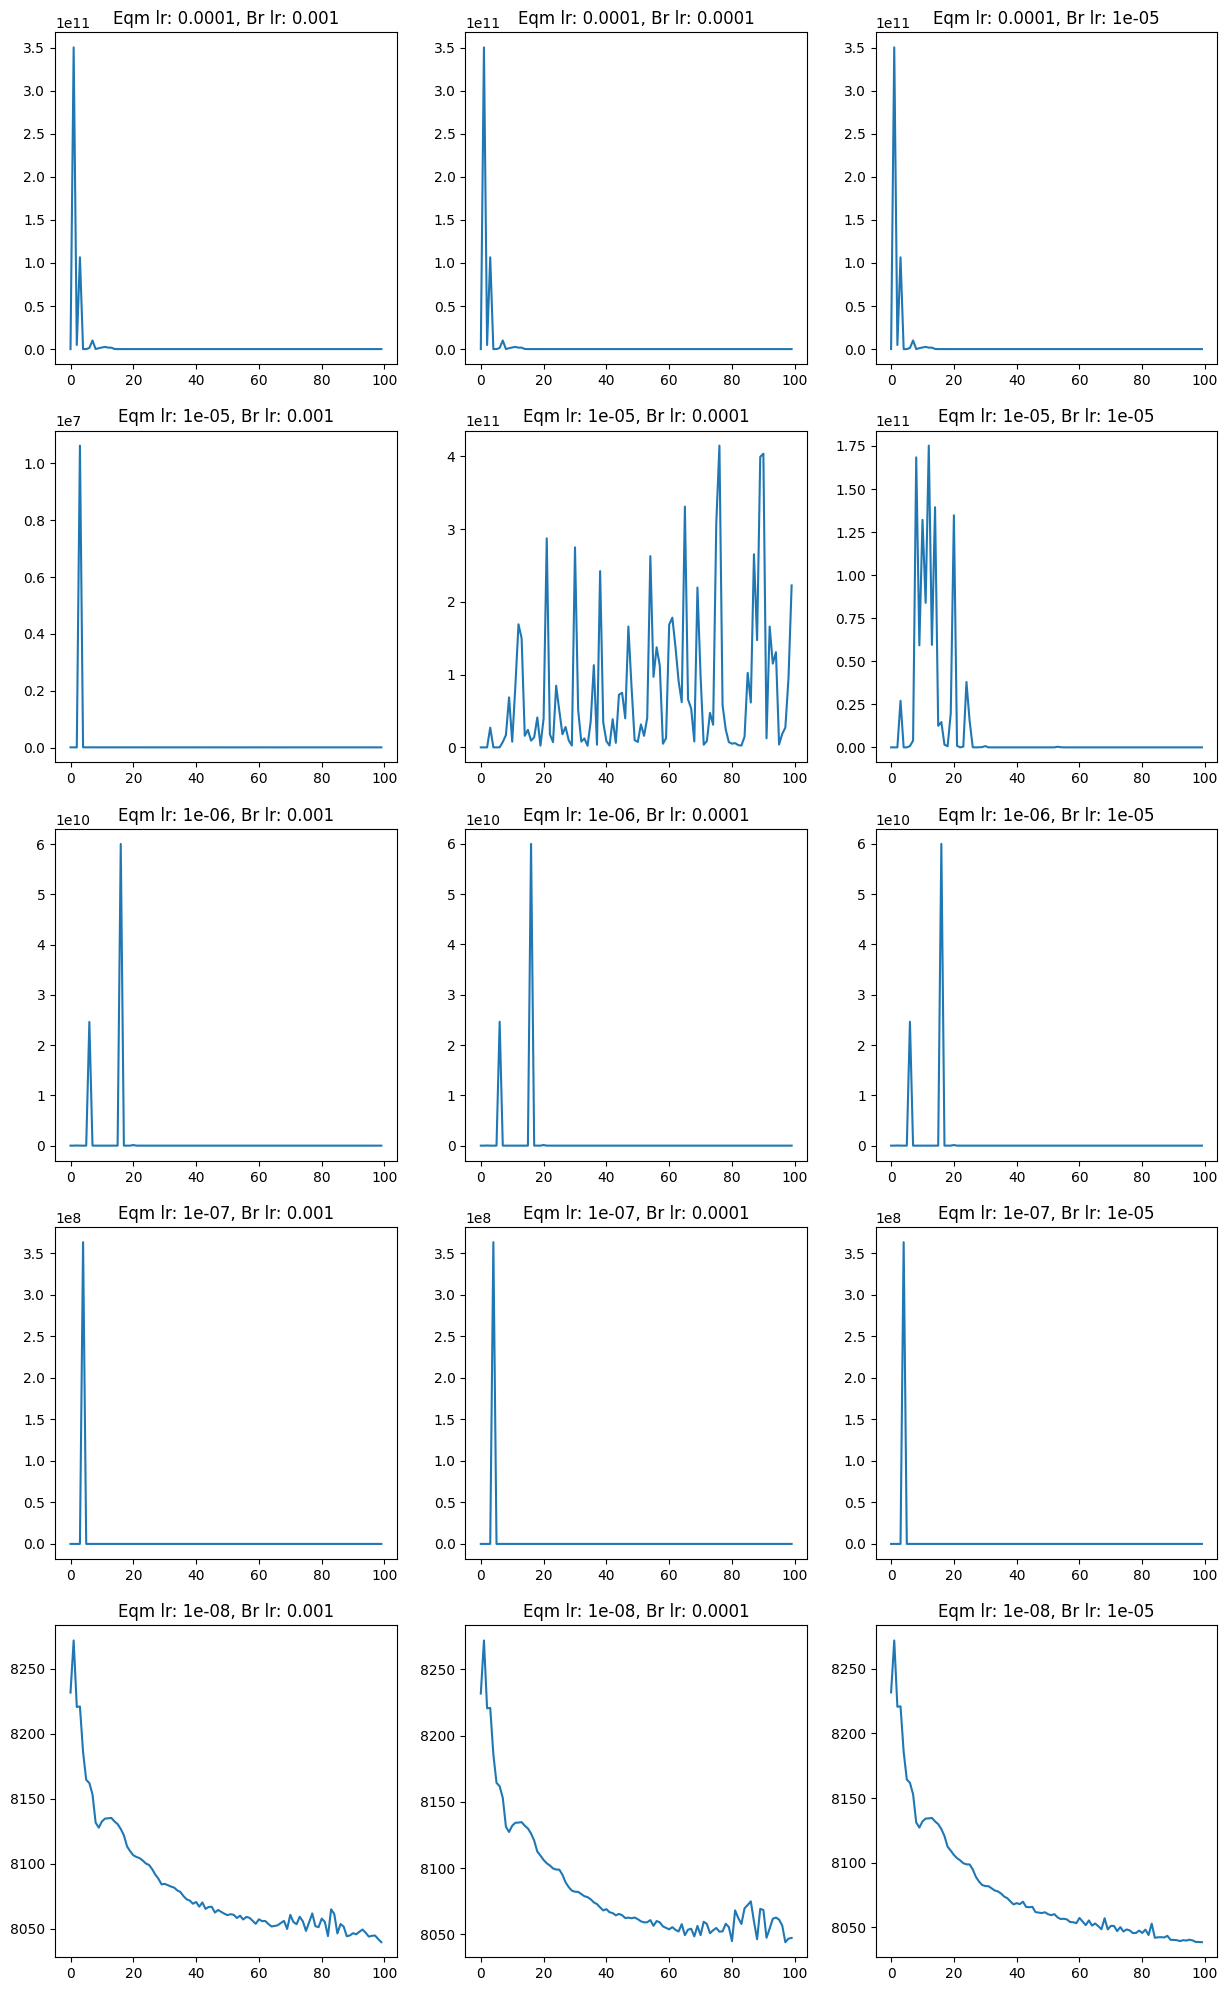

In [16]:
plot_loss_dict(data_cumul_regrets_linear)

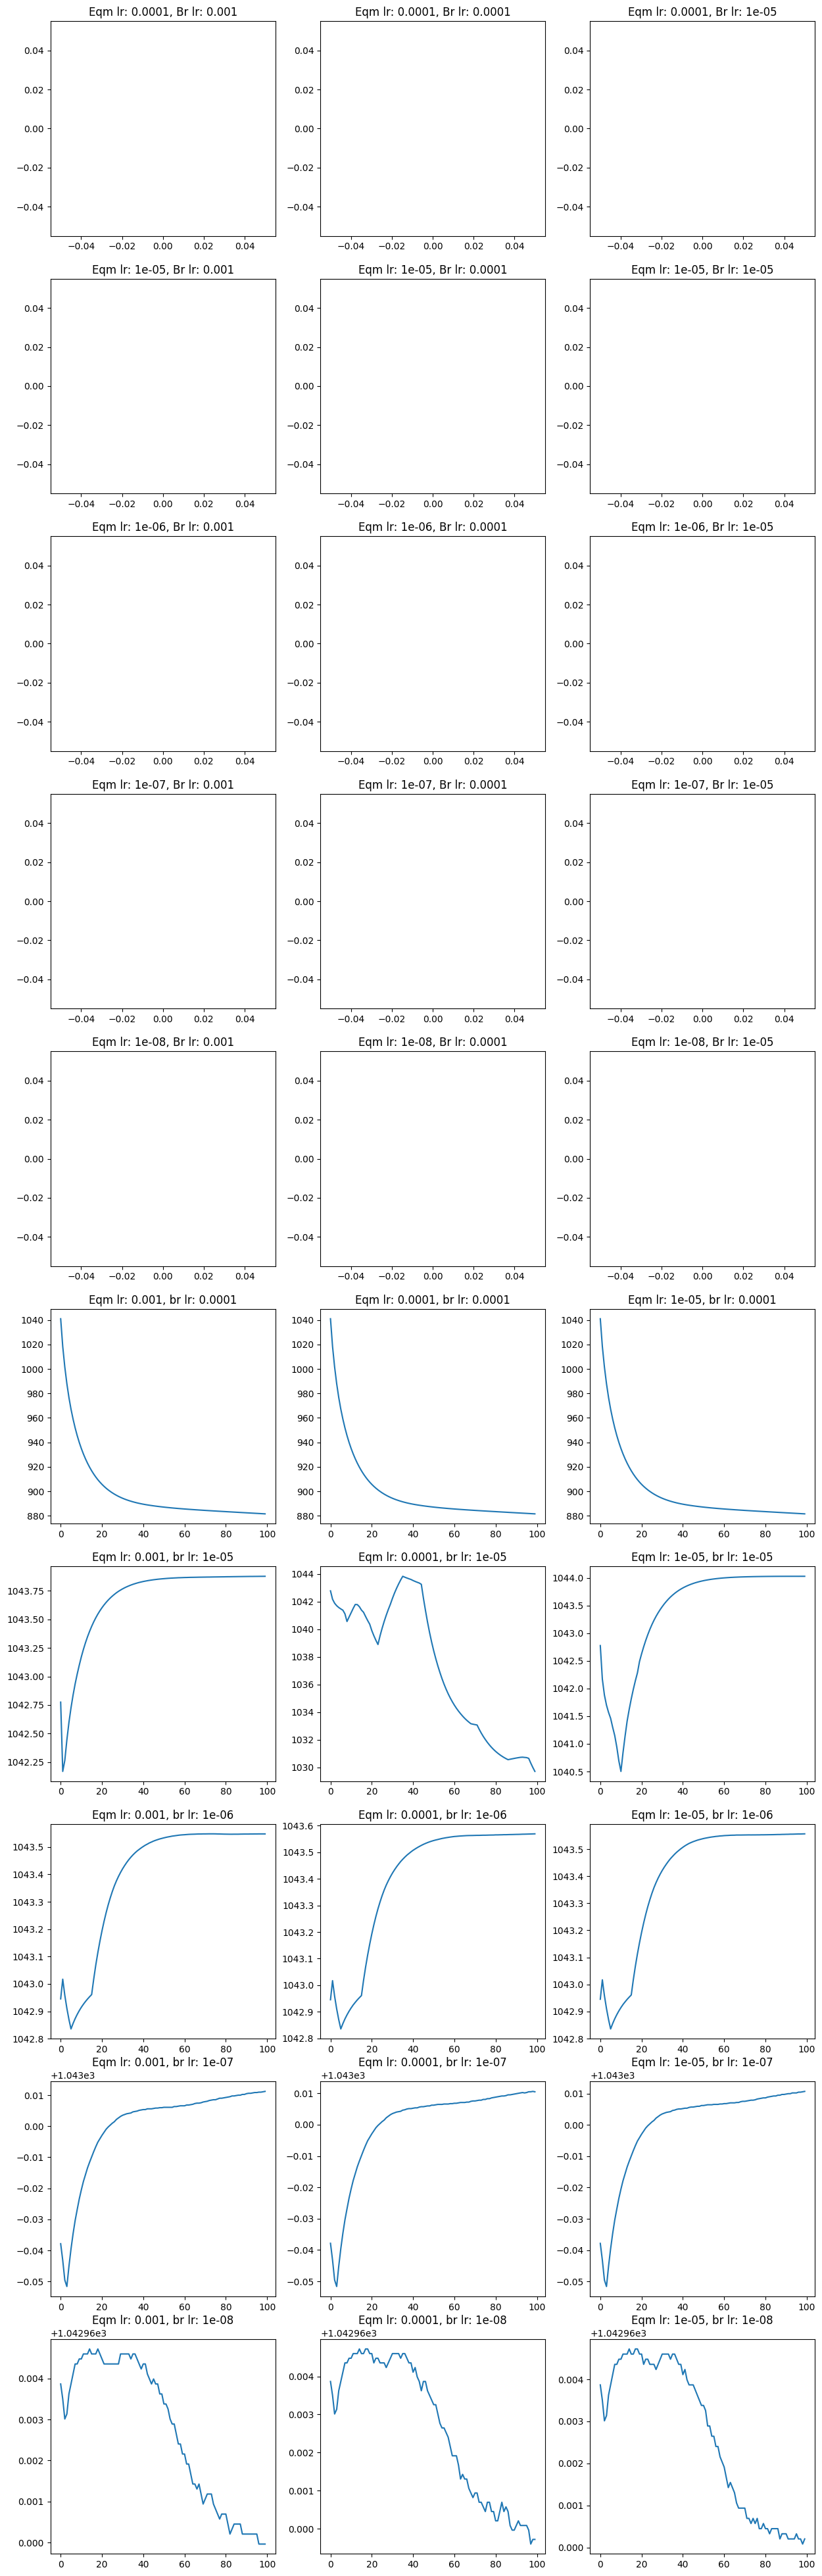

In [17]:
plot_loss_dict(data_avg_excess_demand_linear)

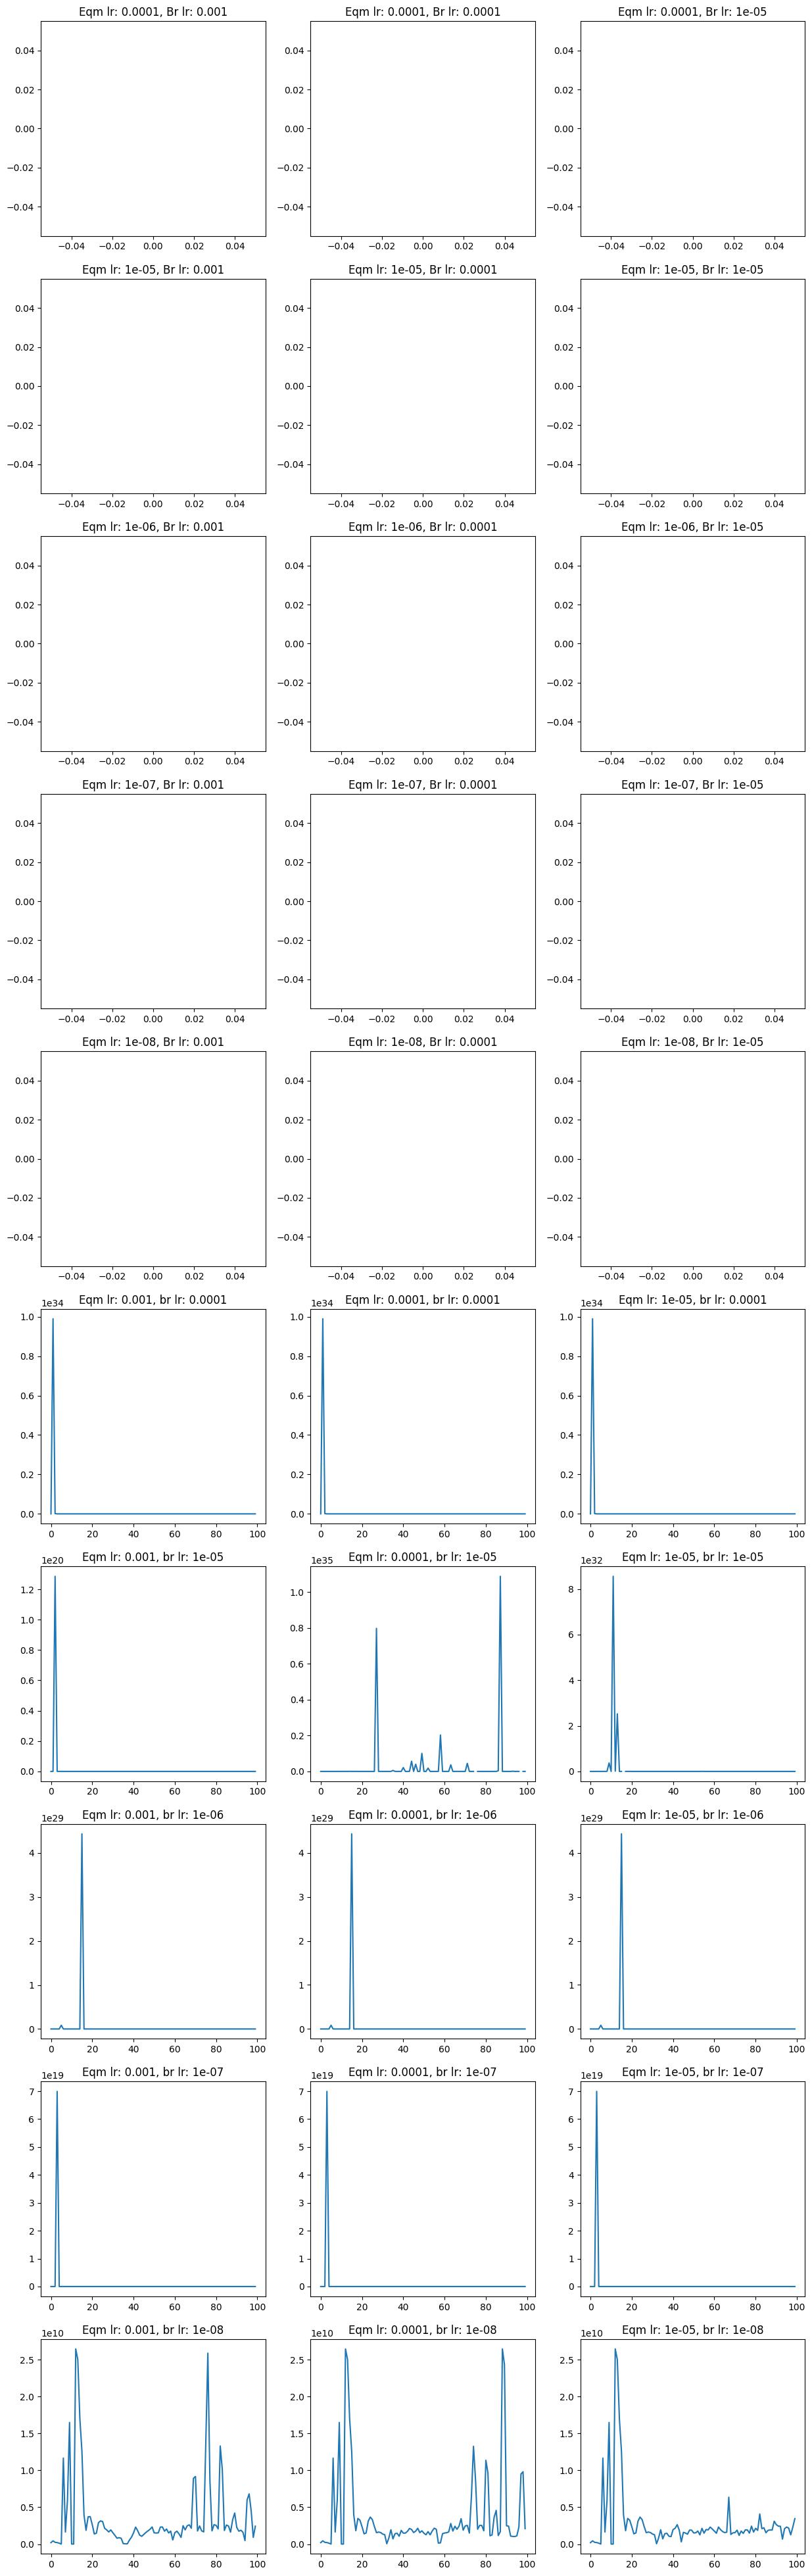

In [18]:
plot_loss_dict(data_consumer_first_order_violations_linear)

#### Final Result

In [ ]:
def plot_losses(losses1, losses2, losses3):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].plot(losses1)
    axs[0].set_title('Losses 1')
    
    axs[1].plot(losses2)
    axs[1].set_title('Losses 2')
    
    axs[2].plot(losses3)
    axs[2].set_title('Losses 3')
    
    plt.show()



### Cobb-Douglas

In [19]:
# pyright: reportPrivateImportUsage = none

# Market parameters
key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 7 
num_commods = 5
num_assets = 1
num_world_states = 4
util_type = "Cobb-Douglas"
discount = 0.8
consumer_endow_range = (0.1*max_supply/(num_consumers*num_commods), max_supply/(num_consumers*num_commods))
consumer_type_range = (1.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)


asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods))

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    world_state = state.world_state
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    # Get next world state
    next_world_state =  0 # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    
    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])
    
    # Get next consumer types
    next_consumer_type = consumer_type 
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)    
    
    
def init_state_function(economy: MarkovEconomy) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
     
    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)
    
    # Get next consumer endowments
    init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
    init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)
    
    # Get next consumer types
    init_consumer_valuation = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }
    
    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))

util = UtilityFunction(util_type)

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)


# Initialize training parameters
eqm_lr_sweep = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
br_lr_sweep = [1e-3, 1e-4, 1e-5]


num_samples = 8
num_epochs = 100
num_episodes = 30

data_cumul_regrets_cd = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_excess_demand_cd = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_consumer_first_order_violations_cd = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}

for eqm_lr, br_lr  in product(eqm_lr_sweep, br_lr_sweep):
    print(f"==================== Eqm. lr: {eqm_lr}, Br lr: {br_lr} ====================")

    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    
    (cumul_regrets, avg_excess_demands, consumer_first_order_violations), eqm_network, br_network = exploitability_minimization(economy, eqm_lr, br_lr, num_epochs, num_samples, num_episodes)

        
    data_cumul_regrets_cd[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = cumul_regrets
    data_avg_excess_demand_cd[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = avg_excess_demands
    data_consumer_first_order_violations_cd[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = consumer_first_order_violations
    
    
# Create a folder to store the dictionaries
folder_name = "data"
os.makedirs(folder_name, exist_ok=True)

# Save the dictionaries as files inside the folder
data_cumul_regrets_cd_file = os.path.join(folder_name, "data_cumul_regrets_cd.pkl")
data_avg_excess_demand_cd_file = os.path.join(folder_name, "data_avg_excess_demand_cd.pkl")
data_consumer_first_order_violations_cd_file = os.path.join(folder_name, "data_consumer_first_order_violations_cd.pkl")

# Save the dictionaries as files
with open(data_cumul_regrets_cd_file, "wb") as f:
    pickle.dump(data_cumul_regrets_cd, f)

with open(data_avg_excess_demand_cd_file, "wb") as f:
    pickle.dump(data_avg_excess_demand_cd, f)

with open(data_consumer_first_order_violations_cd_file, "wb") as f:
    pickle.dump(data_consumer_first_order_violations_cd, f)

==================== Eqm. lr: 0.0001, Br lr: 0.001 ====================
==================== Epoch 0 ====================
Cumulative Regret: nan
Average excess demand: nan
Consumer first order violation: nan
==================== Epoch 1 ====================
Cumulative Regret: nan
Average excess demand: nan
Consumer first order violation: nan
==================== Epoch 2 ====================
Cumulative Regret: nan
Average excess demand: nan
Consumer first order violation: nan
==================== Epoch 3 ====================
Cumulative Regret: nan
Average excess demand: nan
Consumer first order violation: nan
==================== Epoch 4 ====================
Cumulative Regret: nan
Average excess demand: nan
Consumer first order violation: nan
==================== Epoch 5 ====================
Cumulative Regret: nan
Average excess demand: nan
Consumer first order violation: nan
==================== Epoch 6 ====================
Cumulative Regret: nan
Average excess demand: nan
Consumer fir

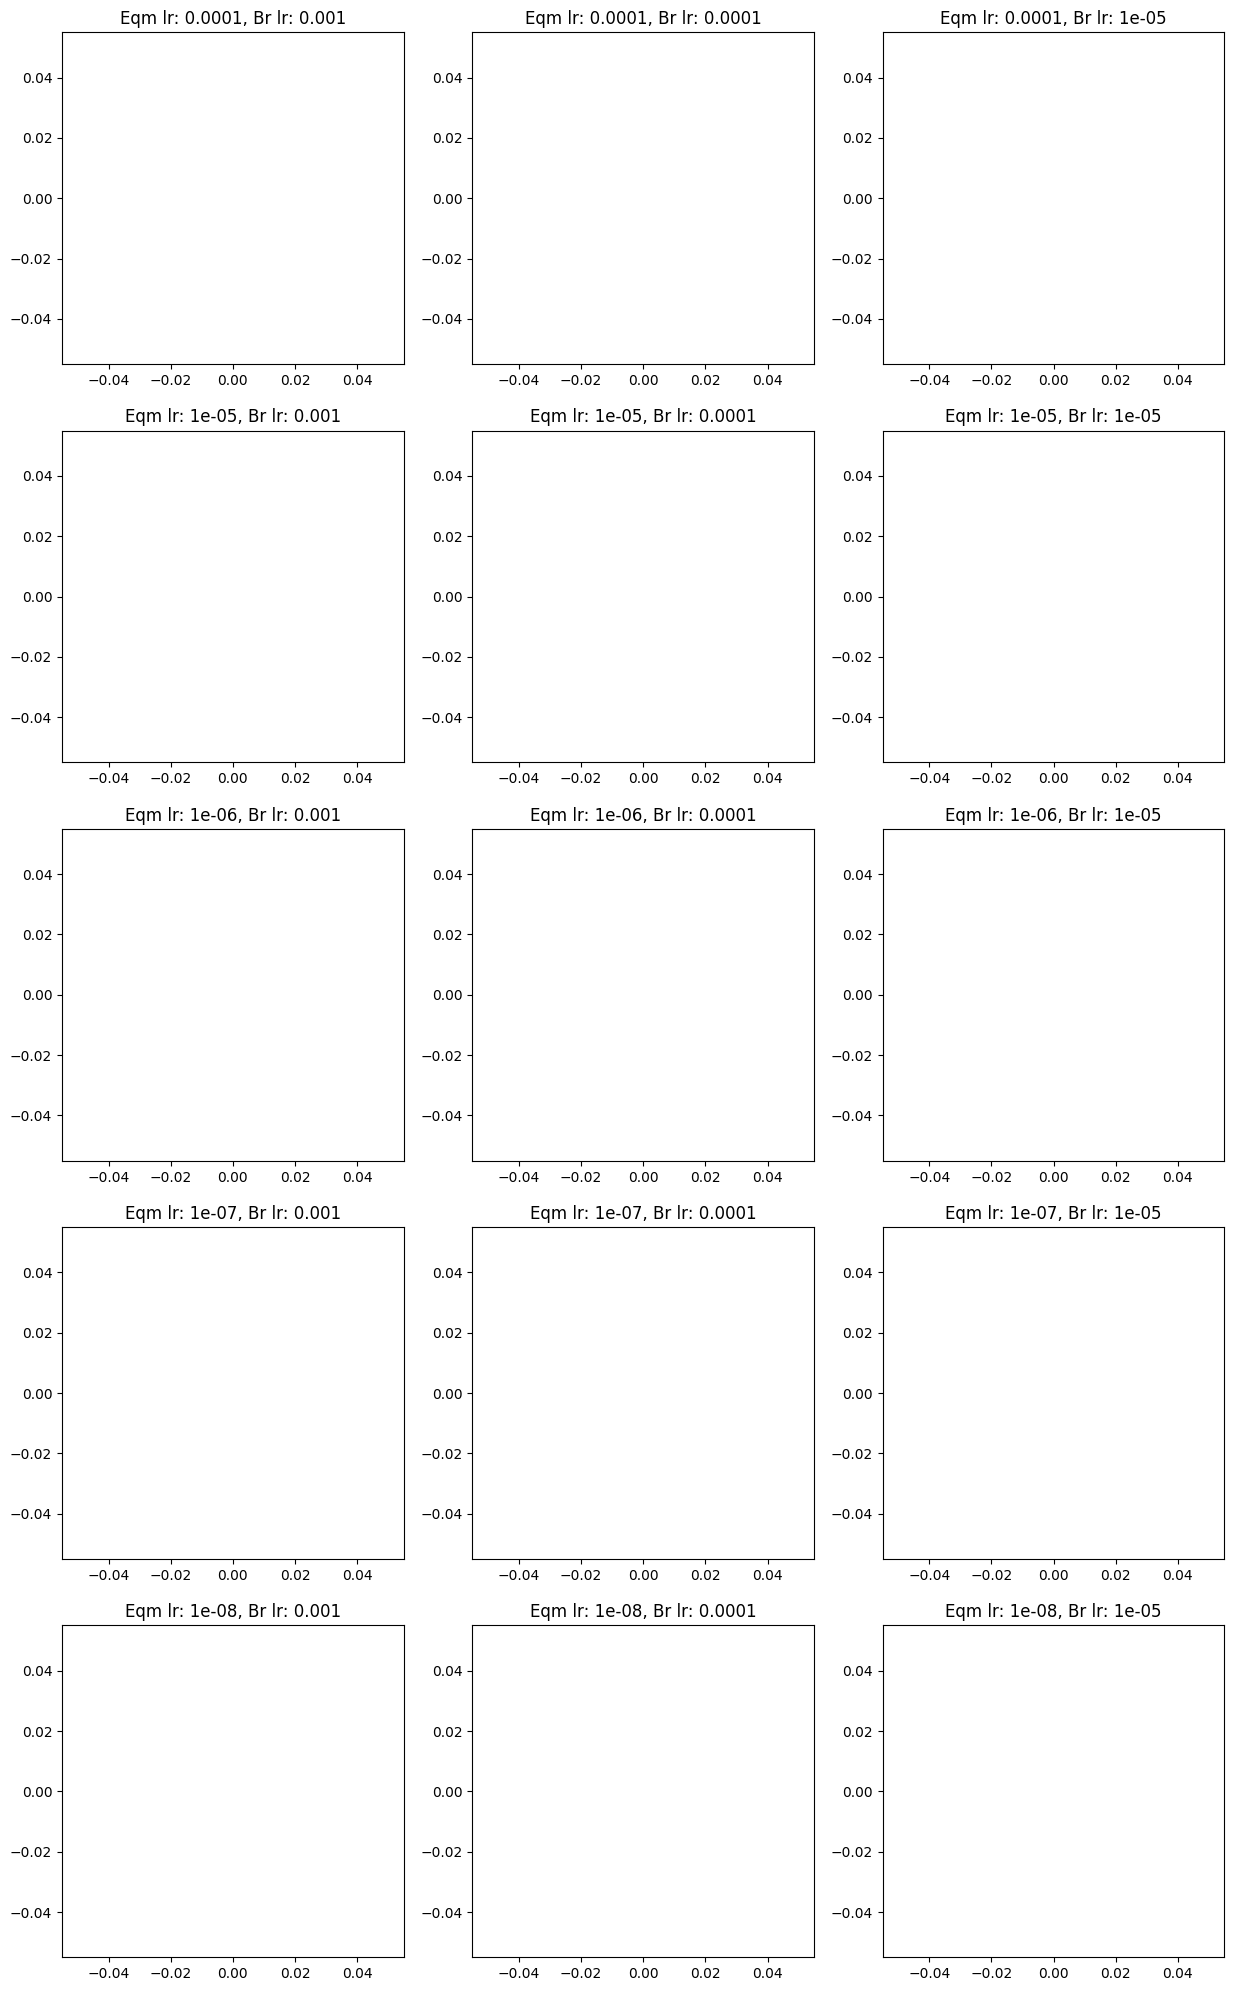

In [20]:
plot_loss_dict(data_cumul_regrets_cd)

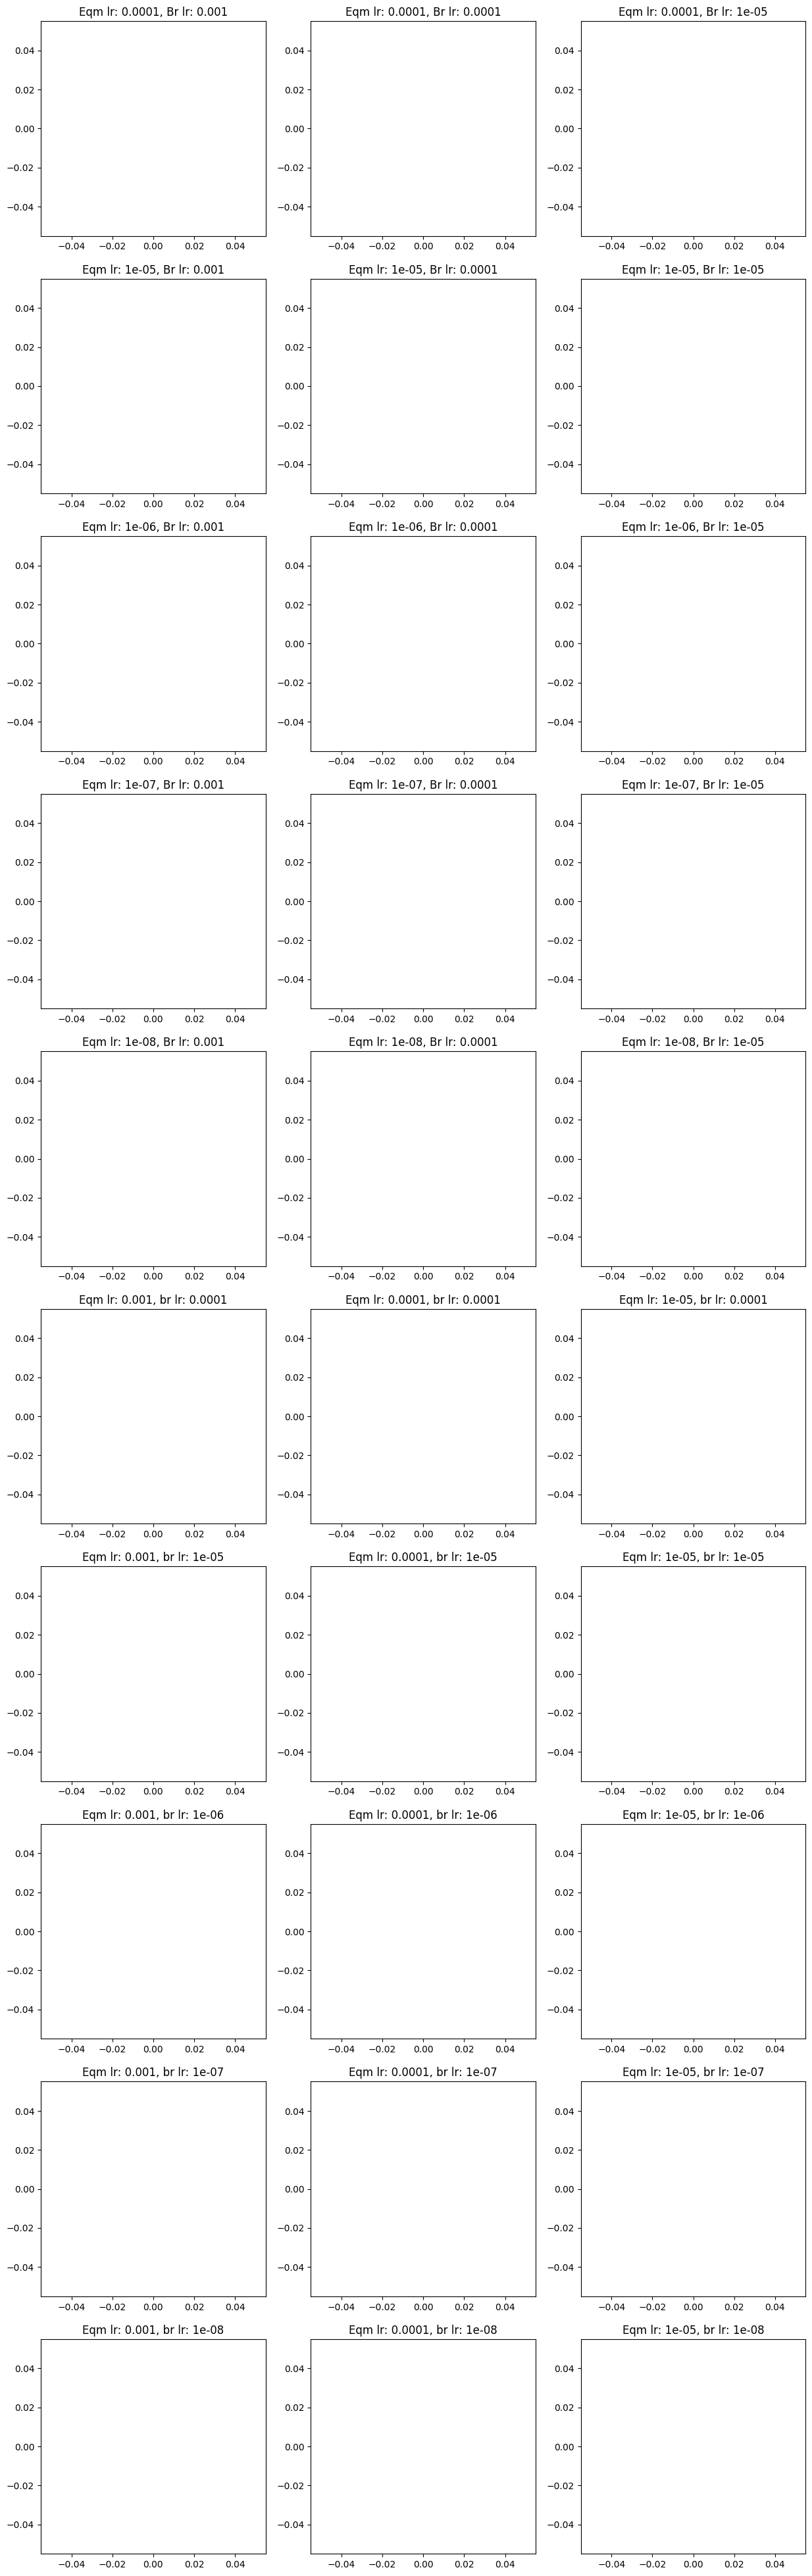

In [21]:
plot_loss_dict(data_avg_excess_demand_cd)

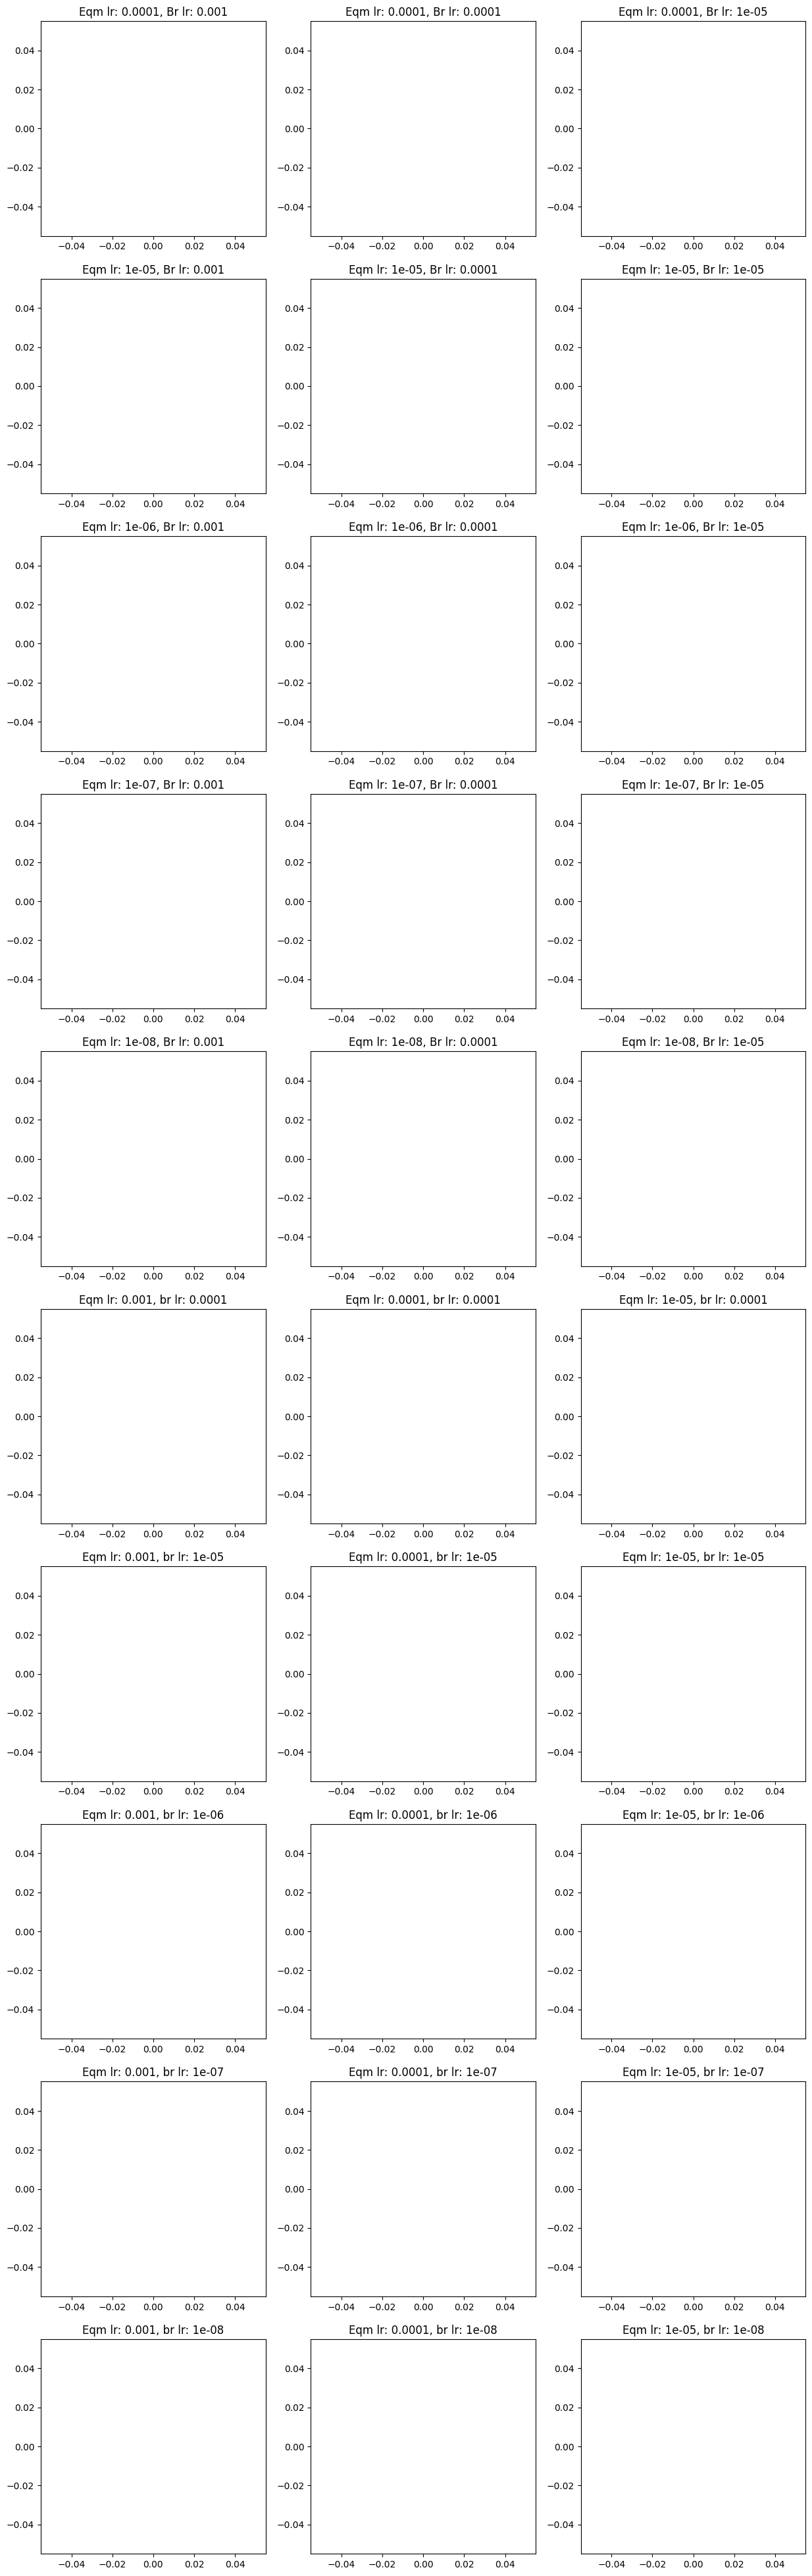

In [22]:
plot_loss_dict(data_consumer_first_order_violations_cd)

### Leontief Economy

In [23]:

# pyright: reportPrivateImportUsage = none

# Market parameters
key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 7 
num_commods = 5
num_assets = 1
num_world_states = 4
util_type = "Leontief"
discount = 0.8
consumer_endow_range = (0.1*max_supply/(num_consumers*num_commods), max_supply/(num_consumers*num_commods))
consumer_type_range = (1.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)


asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods))

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    world_state = state.world_state
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    # Get next world state
    next_world_state =  0 # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    
    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])
    
    # Get next consumer types
    next_consumer_type = consumer_type 
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)    
    
    
def init_state_function(economy: MarkovEconomy) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
     
    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)
    
    # Get next consumer endowments
    init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
    init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)
    
    # Get next consumer types
    init_consumer_valuation = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }
    
    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))

util = UtilityFunction(util_type)

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)


# Initialize training parameters
eqm_lr_sweep = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
br_lr_sweep = [1e-3, 1e-4, 1e-5]


num_samples = 8
num_epochs = 100
num_episodes = 30

data_cumul_regrets_leontief = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_excess_demand_leontief = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_consumer_first_order_violations_leontief = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}

for eqm_lr, br_lr  in product(eqm_lr_sweep, br_lr_sweep):
    print(f"==================== Eqm. lr: {eqm_lr}, Br lr: {br_lr} ====================")

    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    
    (cumul_regrets, avg_excess_demands, consumer_first_order_violations), eqm_network, br_network = exploitability_minimization(economy, eqm_lr, br_lr, num_epochs, num_samples, num_episodes)

        
    data_cumul_regrets_leontief[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = cumul_regrets
    data_avg_excess_demand_leontief[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = avg_excess_demands
    data_consumer_first_order_violations_leontief[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = consumer_first_order_violations
    
# Create a folder to store the dictionaries
folder_name = "data"
os.makedirs(folder_name, exist_ok=True)

# Save the dictionaries as files inside the folder
data_cumul_regrets_file = os.path.join(folder_name, "data_cumul_regrets_leontief.pkl")
data_avg_excess_demand_leontief_file = os.path.join(folder_name, "data_avg_excess_demand_leontief.pkl")
data_consumer_first_order_violations_leontief_file = os.path.join(folder_name, "data_consumer_first_order_violations_leontief.pkl")

# Save the dictionaries as files
with open(data_cumul_regrets_file, "wb") as f:
    pickle.dump(data_cumul_regrets_leontief, f)

with open(data_avg_excess_demand_leontief_file, "wb") as f:
    pickle.dump(data_avg_excess_demand_leontief, f)

with open(data_consumer_first_order_violations_leontief_file, "wb") as f:
    pickle.dump(data_consumer_first_order_violations_leontief, f)


==================== Eqm. lr: 0.0001, Br lr: 0.001 ====================
==================== Epoch 0 ====================
Cumulative Regret: 8245.2001953125
Average excess demand: 1041.926513671875
Consumer first order violation: 667073.0625
==================== Epoch 1 ====================
Cumulative Regret: 9497.93359375
Average excess demand: 1046.21923828125
Consumer first order violation: 0.23780611157417297
==================== Epoch 2 ====================
Cumulative Regret: 7421.95458984375
Average excess demand: 1049.883056640625
Consumer first order violation: 0.22970160841941833
==================== Epoch 3 ====================
Cumulative Regret: 7118.52734375
Average excess demand: 1052.8658447265625
Consumer first order violation: 0.2188841551542282
==================== Epoch 4 ====================
Cumulative Regret: 6848.6630859375
Average excess demand: 1055.371826171875
Consumer first order violation: 0.2126297801733017
==================== Epoch 5 ====================
C

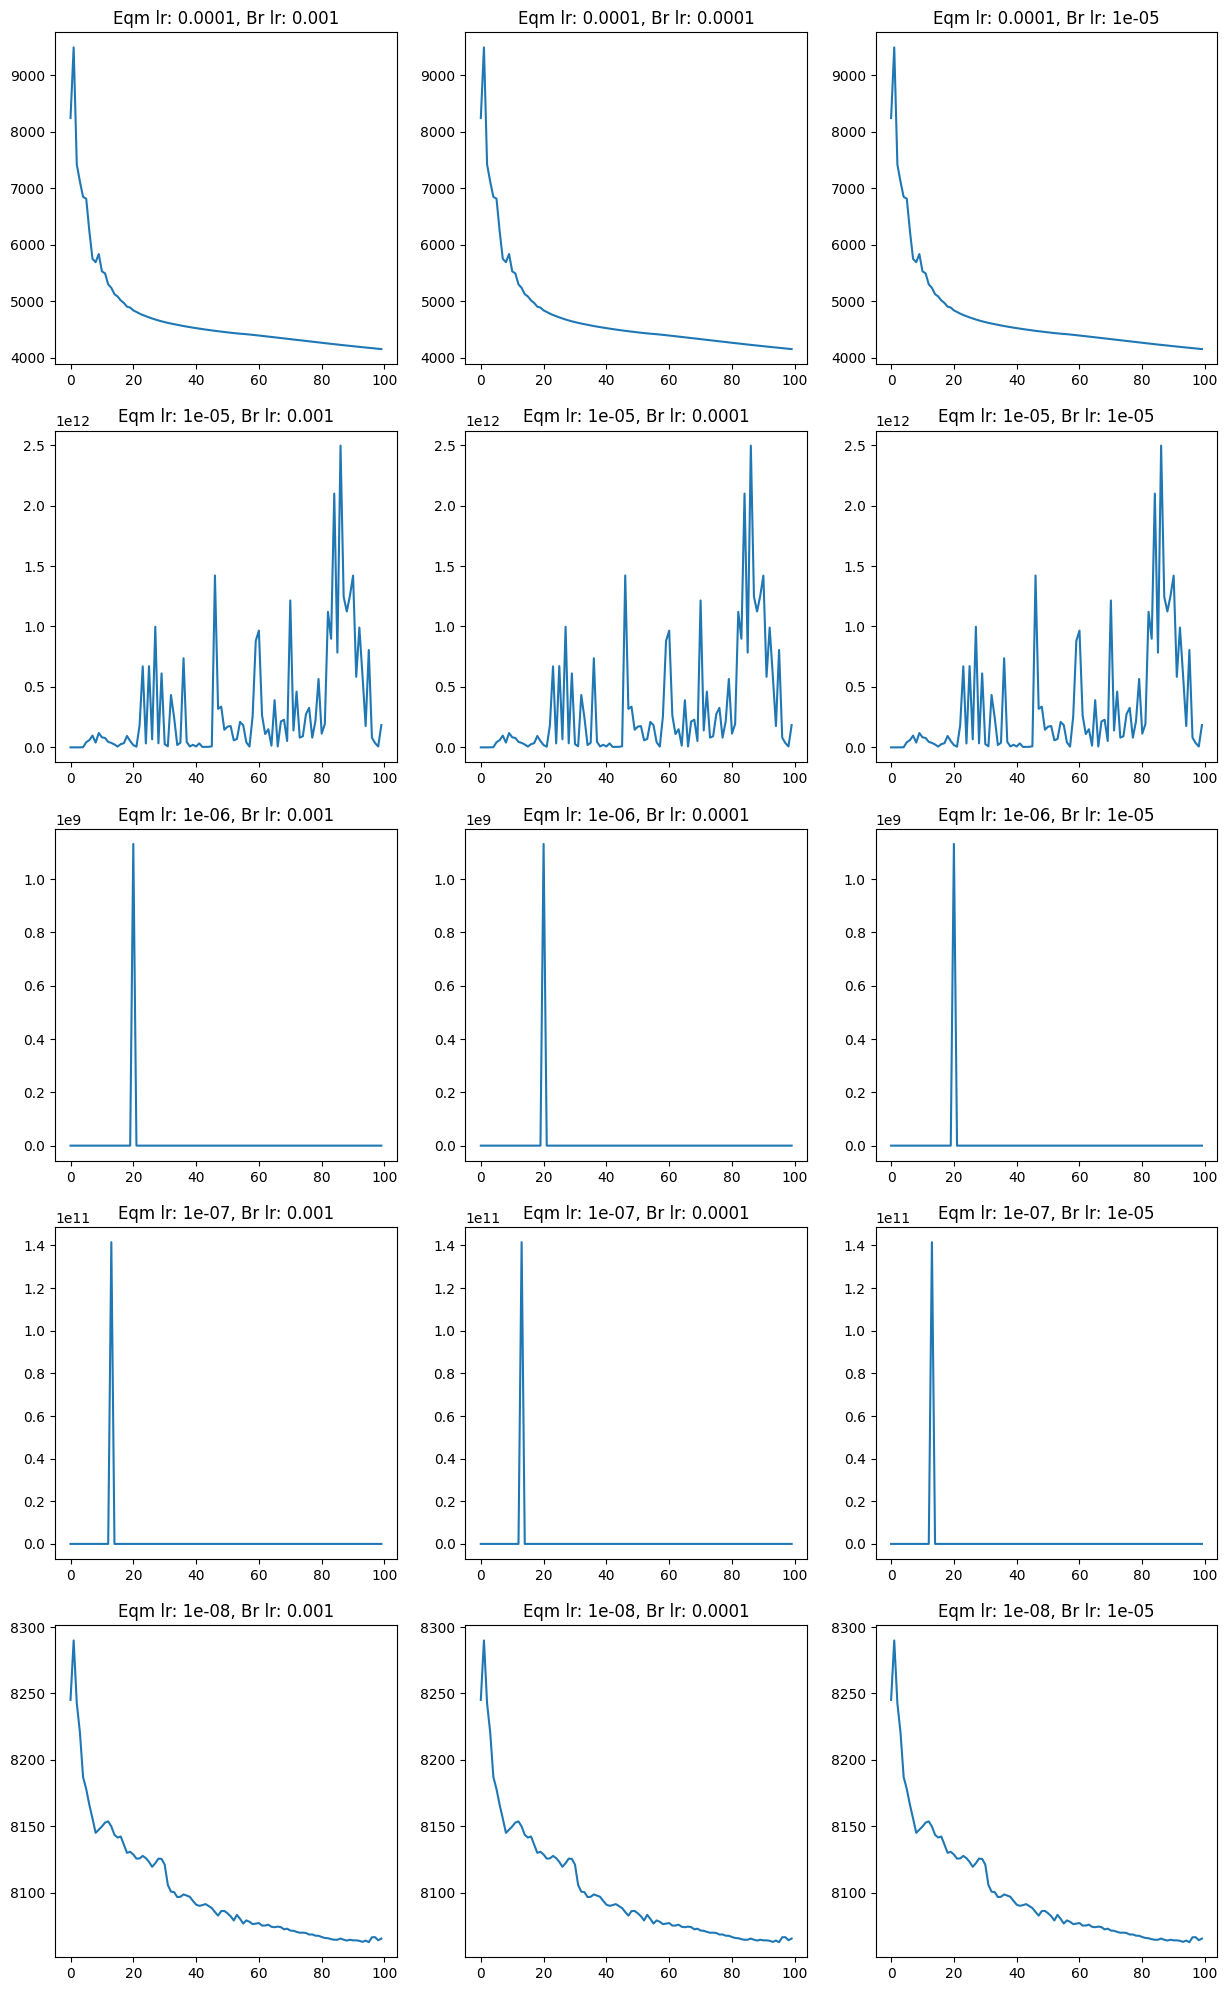

In [24]:
plot_loss_dict(data_cumul_regrets_leontief)

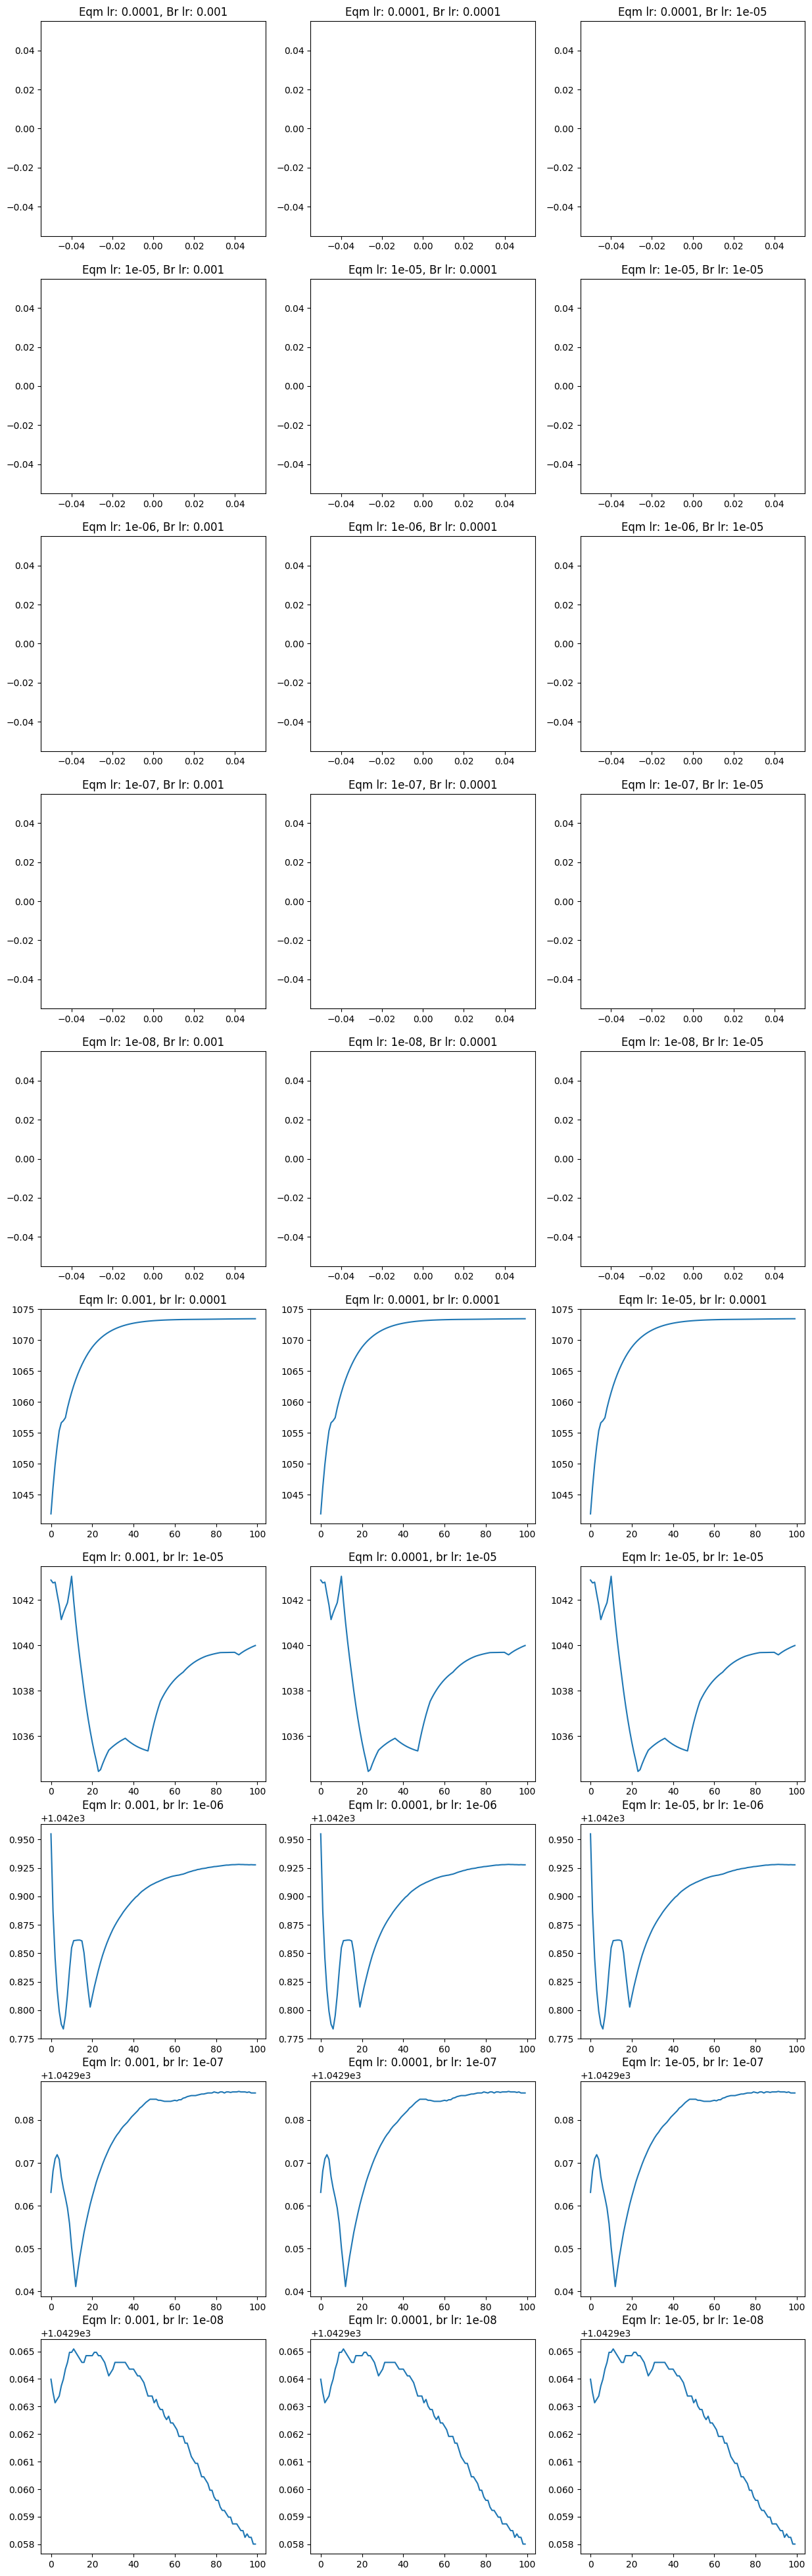

In [25]:
plot_loss_dict(data_avg_excess_demand_leontief)

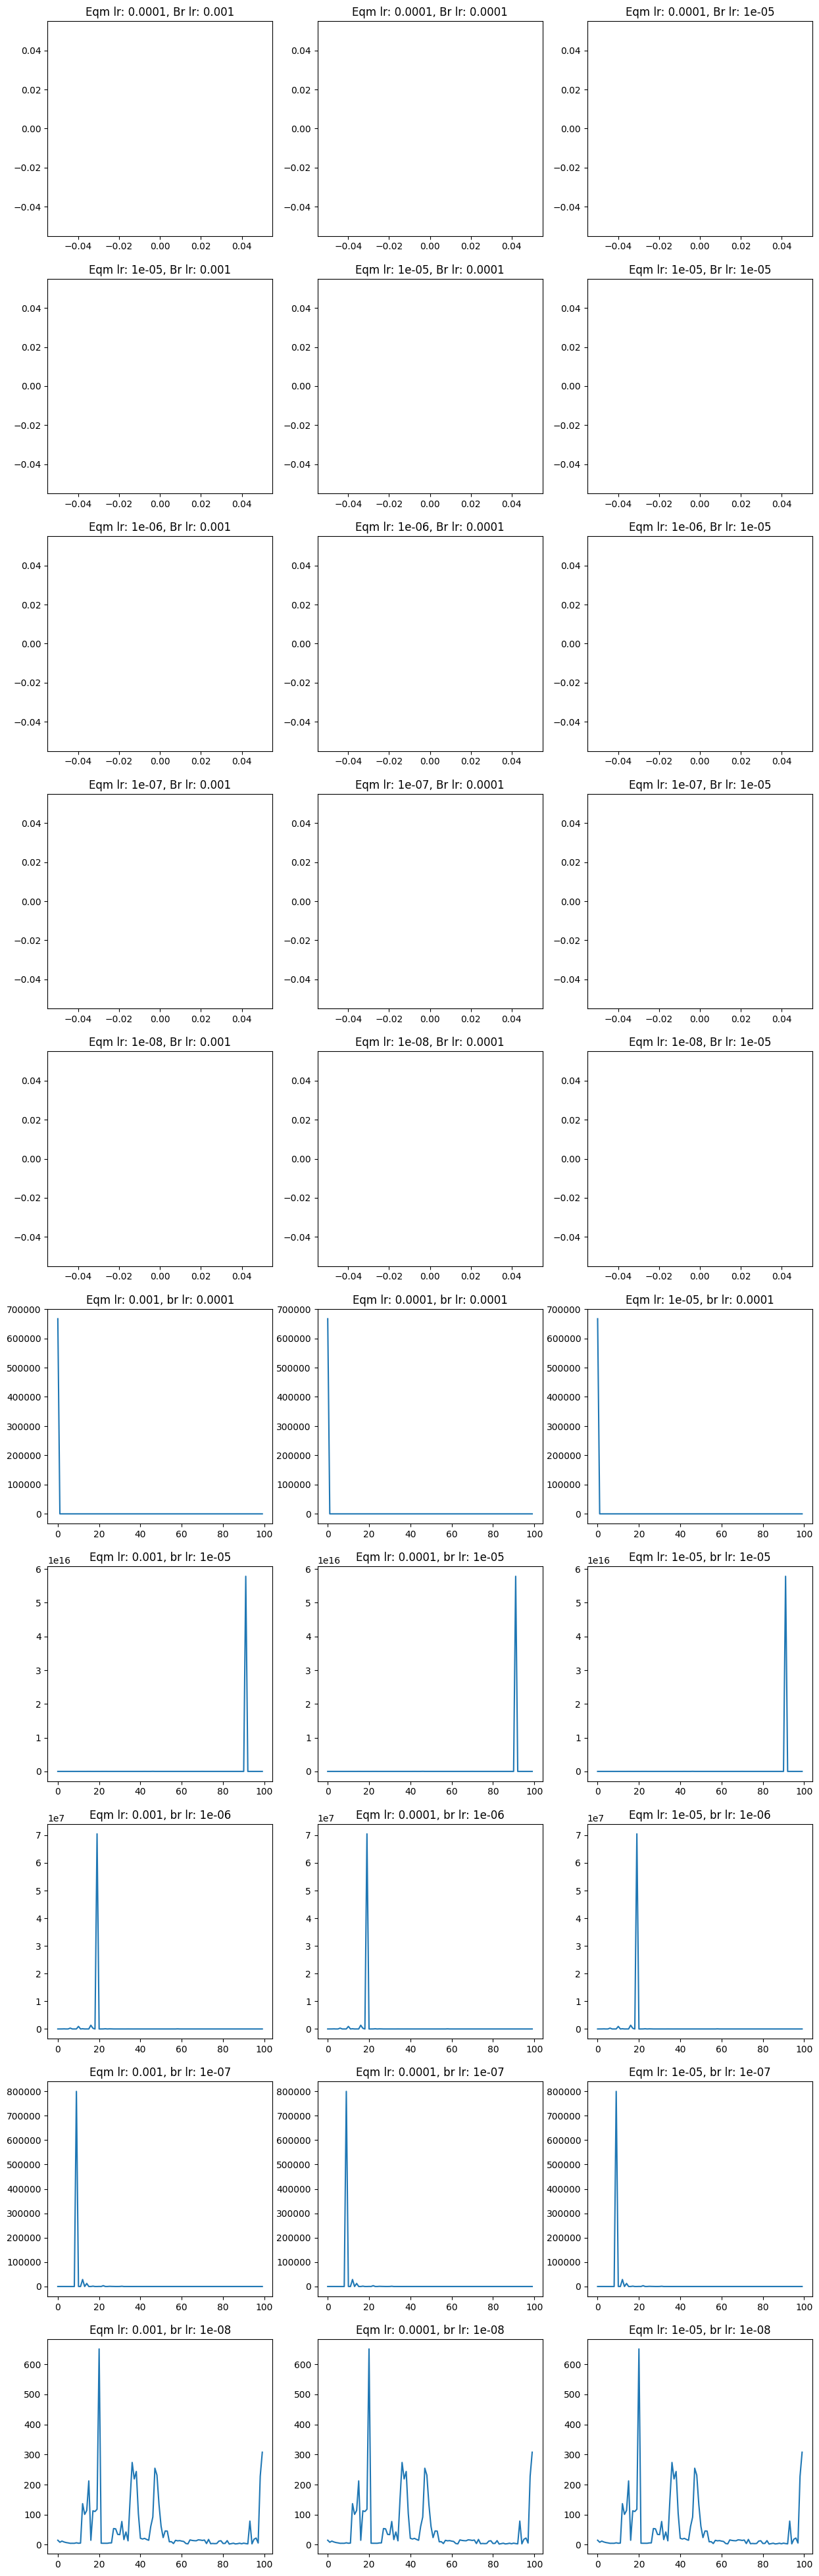

In [26]:
plot_loss_dict(data_consumer_first_order_violations_leontief)

In [10]:
num_episodes = 50
num_samples = 1
num_epochs = 1500
eqm_lr = 1e-4
neural_projection_method(economy, eqm_lr, num_epochs, num_samples, num_episodes)

==================== Epoch 0 ====================
First-Order Loss: 8.075559303075227e+20
==================== Epoch 1 ====================
First-Order Loss: 8.081021324998298e+20
==================== Epoch 2 ====================
First-Order Loss: 8.073559423365698e+20
==================== Epoch 3 ====================
First-Order Loss: 8.09054784558507e+20
==================== Epoch 4 ====================
First-Order Loss: 8.076239065143983e+20
==================== Epoch 5 ====================
First-Order Loss: 8.077918063380063e+20
==================== Epoch 6 ====================
First-Order Loss: 8.082922688465978e+20
==================== Epoch 7 ====================
First-Order Loss: 2.074376295235453e+18
==================== Epoch 8 ====================
First-Order Loss: 2.0712725113491948e+18
==================== Epoch 9 ====================
First-Order Loss: 2.33886739070976e+18
==================== Epoch 10 ====================
First-Order Loss: 1.5673024232260895e+18
=========

KeyboardInterrupt: 

In [26]:
# Initialize training parameters
eqm_lr_sweep = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
br_lr_sweep = [1e-3, 1e-4, 1e-5]


num_samples = 8
num_epochs = 500
num_episodes = 30

data_cumul_regrets = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_excess_demand = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_consumer_first_order_violations = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}

for eqm_lr, br_lr  in product(eqm_lr_sweep, br_lr_sweep):
    print(f"==================== Eqm. lr: {eqm_lr}, Br lr: {br_lr} ====================")

    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    # (losses, avg_excess_demands, bang_per_buck_diffs), eqm_network, br_network = train(economy, eqm_lr, br_lr, num_epochs, num_episodes)
    
    (cumul_regrets, avg_excess_demands, consumer_first_order_violations), eqm_network, br_network = exploitability_minimization(economy, eqm_lr, br_lr, num_epochs, num_samples, num_episodes)

        
    data_cumul_regrets[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = cumul_regrets
    data_avg_excess_demand[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = avg_excess_demands
    data_consumer_first_order_violations[f"Eqm lr: {br_lr}, br lr: {eqm_lr}"] = consumer_first_order_violations

==================== Eqm. lr: 0.0001, Br lr: 0.001 ====================
==================== Epoch 0 ====================
Cumulative Regret: 8231.712890625
Average excess demand: 1040.958984375
Consumer first order violation: 1.462348901557101e+28
==================== Epoch 1 ====================
Cumulative Regret: 350217699328.0
Average excess demand: 1018.2890014648438
Consumer first order violation: 9.897566441664099e+33
==================== Epoch 2 ====================
Cumulative Regret: 4741847040.0
Average excess demand: 1001.5252685546875
Consumer first order violation: 1.2631068525352078e+31
==================== Epoch 3 ====================
Cumulative Regret: 106521591808.0
Average excess demand: 987.9274291992188
Consumer first order violation: 6494.8037109375
==================== Epoch 4 ====================
Cumulative Regret: 34857.6171875
Average excess demand: 976.62841796875
Consumer first order violation: 6062.43603515625
==================== Epoch 5 ====================

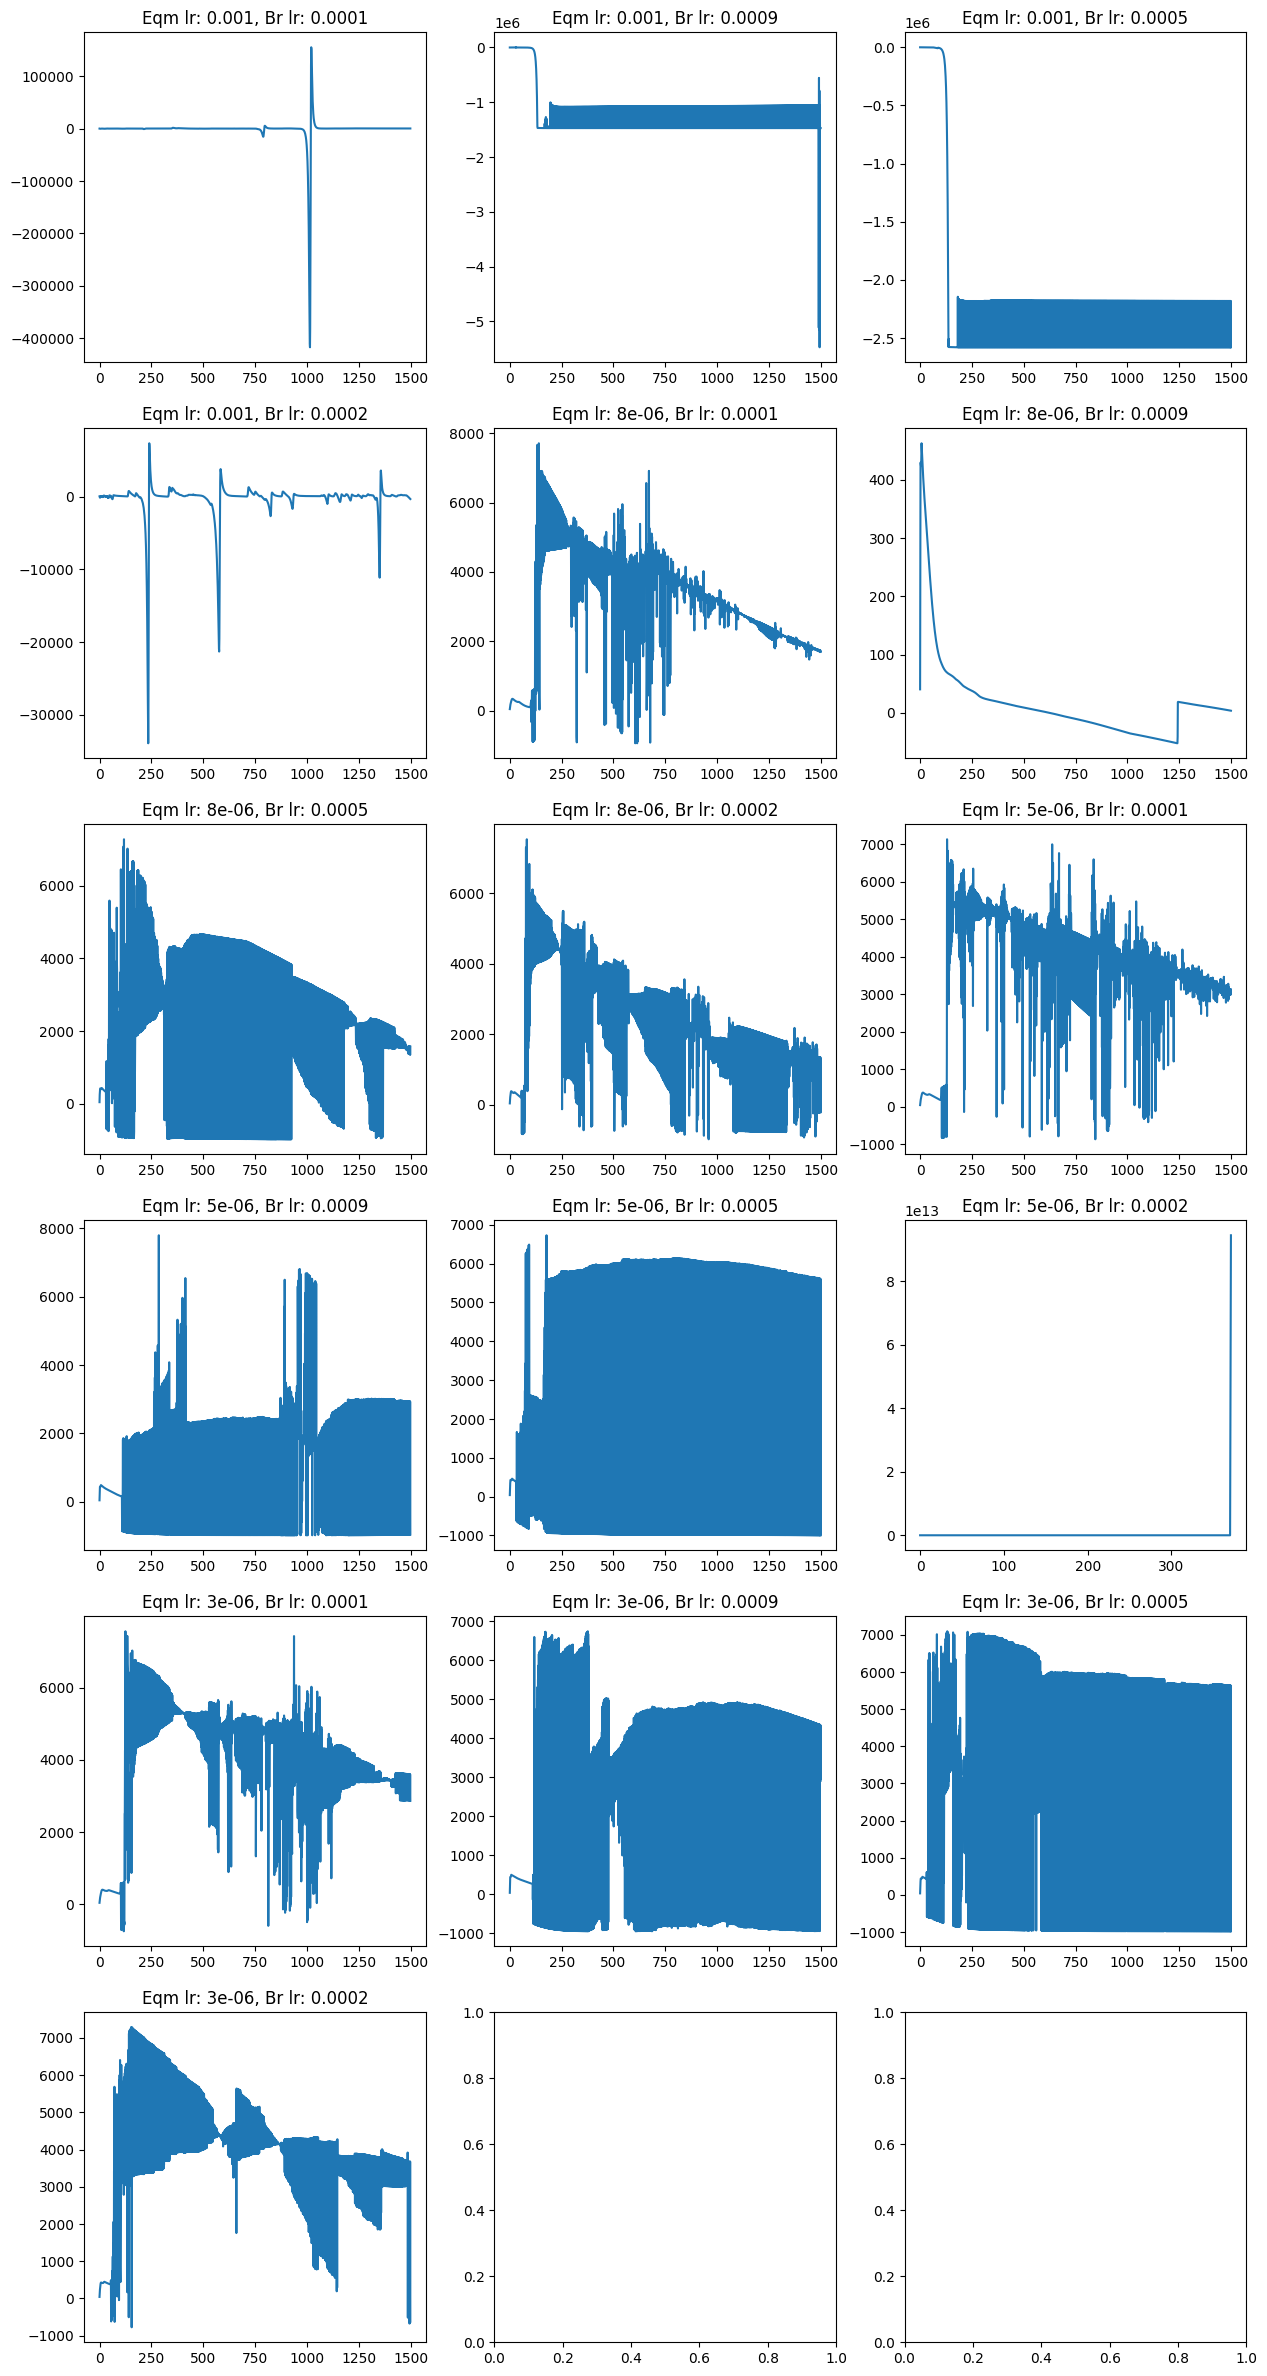

In [155]:
plot_loss_dict(data_cumul_regrets)


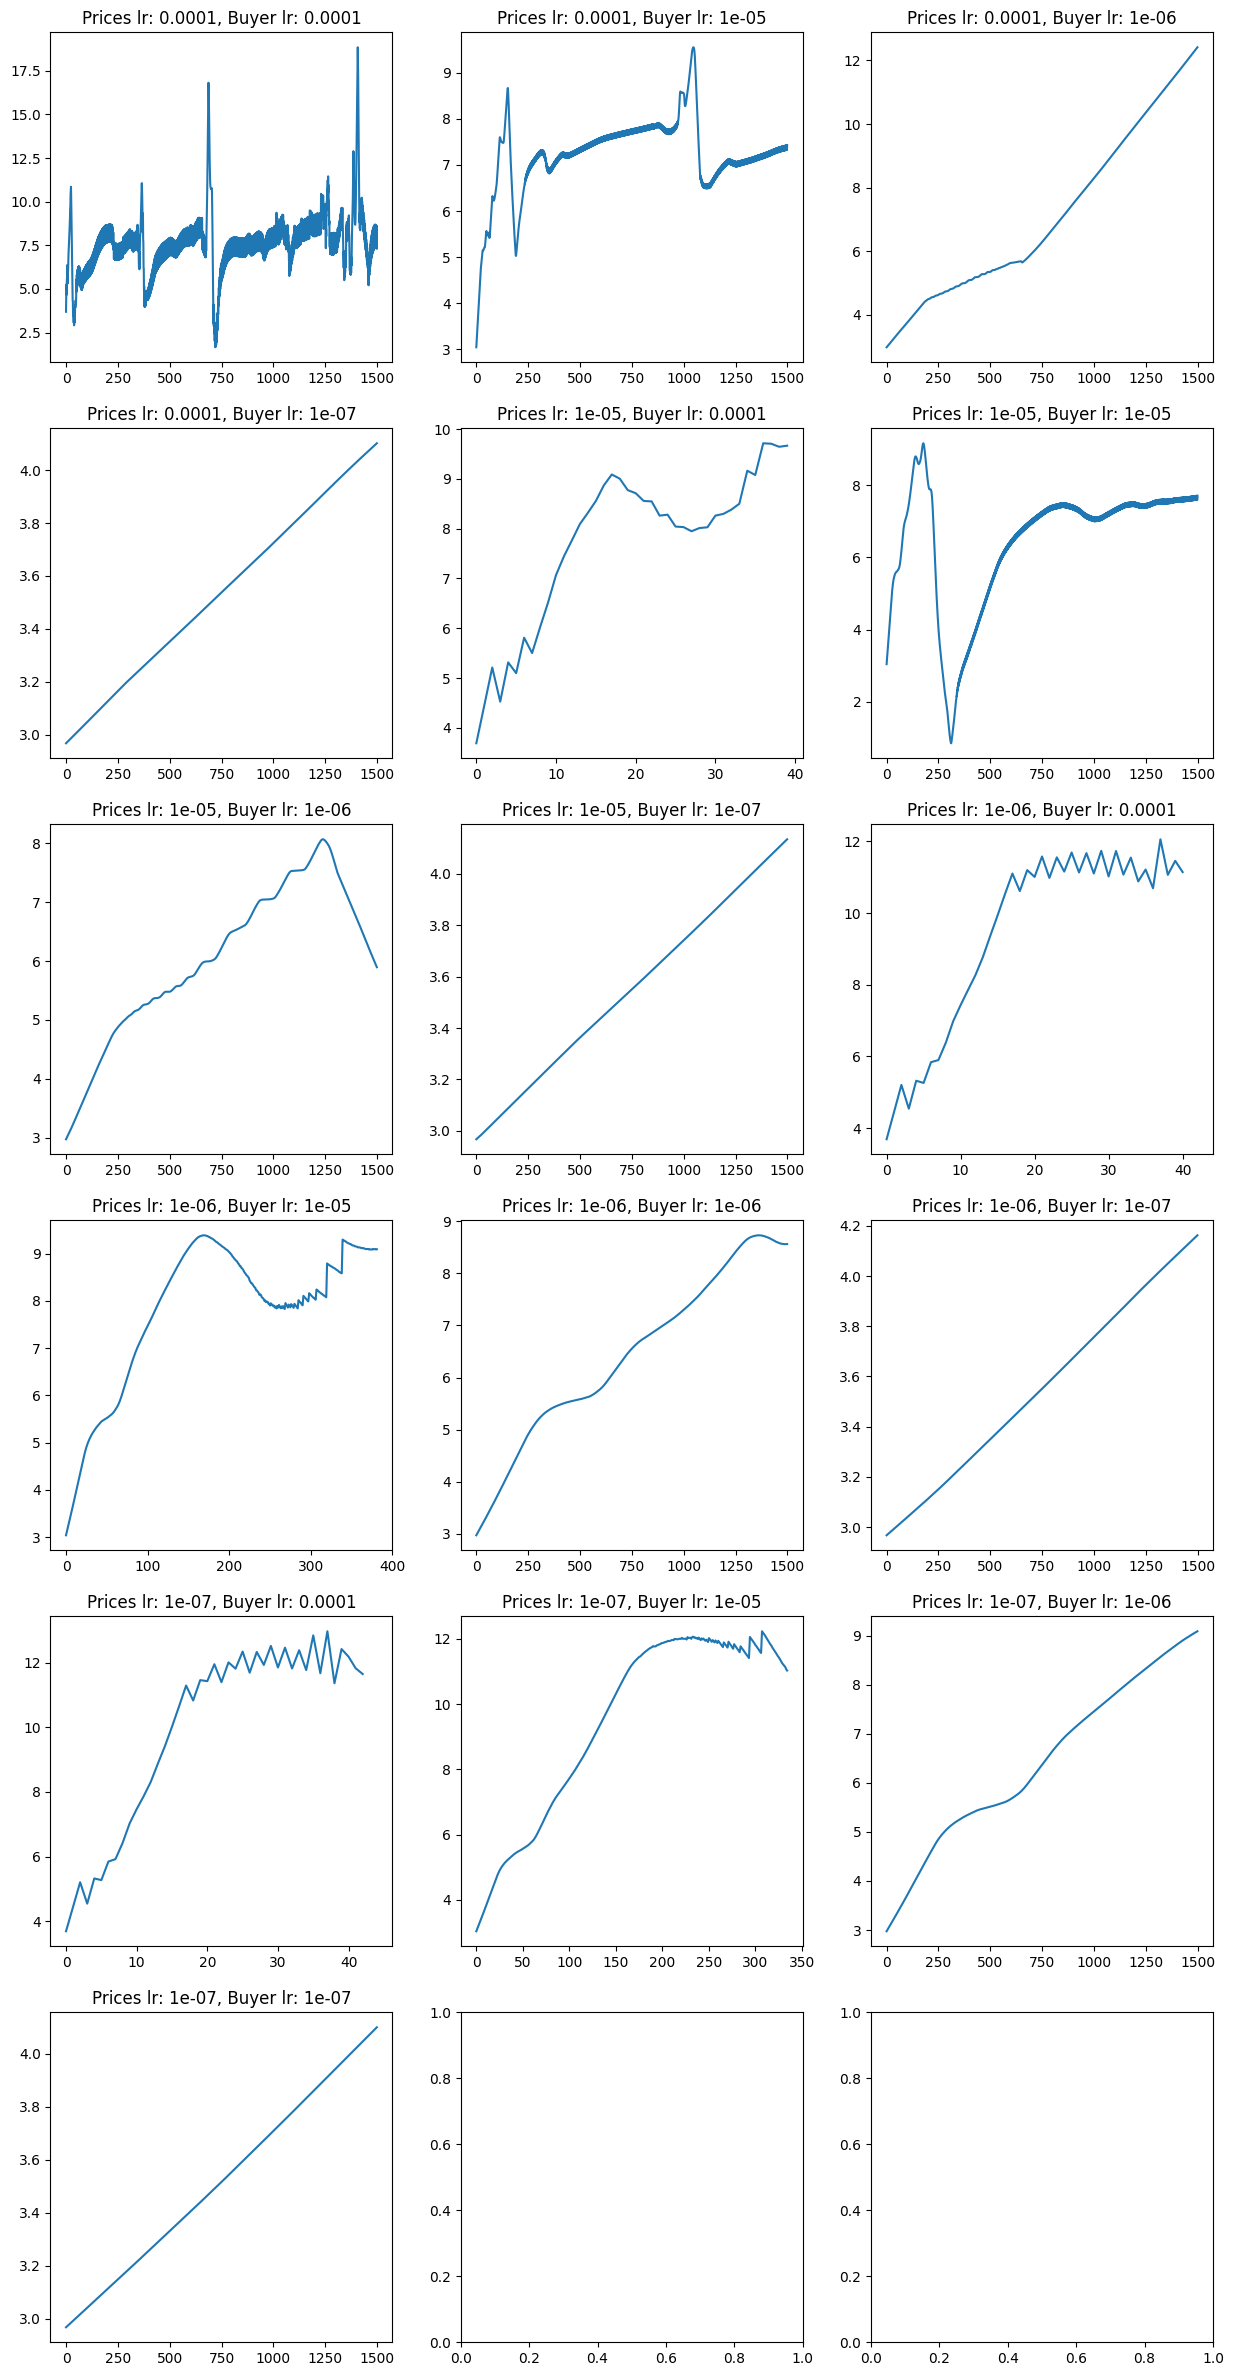

In [67]:
plot_loss_dict(data_bang_per_buck_diffs)

# Final Experiment

## Linear economies

### Exploitability Minimization

In [112]:
# pyright: reportPrivateImportUsage = none

# Market parameters
key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 5
num_commods = 2
num_assets = 2
num_world_states = 1
util_type = "linear"
discount = 0.8
consumer_endow_range = (0.1*max_supply/(num_consumers*num_commods), max_supply/(num_consumers*num_commods))
consumer_type_range = (1.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)


asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods))

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)
init_consumer_valuation = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    
def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    world_state = state.world_state
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    # Get next world state
    next_world_state =  0 # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    
    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])
    
    # Get next consumer types
    next_consumer_type = consumer_type 
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)    
    
    
def init_state_function(economy: MarkovEconomy) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
     
    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)
    
    # Get next consumer endowments
    # Get next consumer types
    
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }
    
    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))

util = UtilityFunction(util_type)

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)

num_samples = 4
num_epochs = 200
num_episodes = 30

(cumul_regrets_linear, total_first_order_violations_linear, _, _), _, _ = exploitability_minimization(economy, 1e-5, 1e-4, num_epochs, num_samples, num_episodes)

==================== Epoch 0 ====================
Cumulative Regret: 390.03692626953125
Total First Order Violation: 352.83740234375
==================== Epoch 1 ====================
Cumulative Regret: 391.0806579589844
Total First Order Violation: 345.545654296875
==================== Epoch 2 ====================
Cumulative Regret: 392.121826171875
Total First Order Violation: 337.3460693359375
==================== Epoch 3 ====================
Cumulative Regret: 265.1456604003906
Total First Order Violation: 328.34075927734375
==================== Epoch 4 ====================
Cumulative Regret: 266.1557922363281
Total First Order Violation: 321.345947265625
==================== Epoch 5 ====================
Cumulative Regret: 331.16925048828125
Total First Order Violation: 314.46038818359375
==================== Epoch 6 ====================
Cumulative Regret: 268.17120361328125
Total First Order Violation: 308.062255859375
==================== Epoch 7 ====================
Cumulative Re

### Neural Projection

In [113]:
# pyright: reportPrivateImportUsage = none

# Market parameters
economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)

num_samples = 4
num_epochs = 200
num_episodes = 30

loss_linear, _ = neural_projection_method(economy, 1e-7, num_epochs, num_samples, num_episodes)

==================== Epoch 0 ====================
First-Order Loss: 359.36944580078125
==================== Epoch 1 ====================
First-Order Loss: 359.18328857421875
==================== Epoch 2 ====================
First-Order Loss: 358.99725341796875
==================== Epoch 3 ====================
First-Order Loss: 358.8108825683594
==================== Epoch 4 ====================
First-Order Loss: 358.62579345703125
==================== Epoch 5 ====================
First-Order Loss: 358.4400634765625
==================== Epoch 6 ====================
First-Order Loss: 358.25408935546875
==================== Epoch 7 ====================
First-Order Loss: 358.06866455078125
==================== Epoch 8 ====================
First-Order Loss: 357.8841247558594
==================== Epoch 9 ====================
First-Order Loss: 357.69830322265625
==================== Epoch 10 ====================
First-Order Loss: 357.5144958496094
==================== Epoch 11 ================

## Cobb-Douglas

### Exploitability Minimization

In [114]:
# pyright: reportPrivateImportUsage = none

key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 5
num_commods = 2
num_assets = 2
num_world_states = 1
util_type = "linear"
discount = 0.8
consumer_endow_range = (0.1*max_supply/(num_consumers*num_commods), max_supply/(num_consumers*num_commods))
consumer_type_range = (2.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)



asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods))

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)
init_consumer_valuation = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    
def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    world_state = state.world_state
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    # Get next world state
    next_world_state =  0 # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    
    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])
    
    # Get next consumer types
    next_consumer_type = consumer_type 
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)    
    
    
def init_state_function(economy: MarkovEconomy) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
     
    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)
    
    # Get next consumer endowments
    # Get next consumer types
    
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }
    
    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))

util = UtilityFunction(util_type)

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)

num_samples = 4
num_epochs = 200
num_episodes = 30

(cumul_regrets_cd, total_first_order_violations_cd, _, _), _, _ = exploitability_minimization(economy, 1e-5, 1e-4, num_epochs, num_samples, num_episodes)


==================== Epoch 0 ====================
Cumulative Regret: 553.3743896484375
Total First Order Violation: 729.0580444335938
==================== Epoch 1 ====================
Cumulative Regret: 523.051513671875
Total First Order Violation: 717.8218383789062
==================== Epoch 2 ====================
Cumulative Regret: 524.732177734375
Total First Order Violation: 701.1148071289062
==================== Epoch 3 ====================
Cumulative Regret: 526.3803100585938
Total First Order Violation: 681.4885864257812
==================== Epoch 4 ====================
Cumulative Regret: 528.0022583007812
Total First Order Violation: 663.1492309570312
==================== Epoch 5 ====================
Cumulative Regret: 529.5873413085938
Total First Order Violation: 644.421875
==================== Epoch 6 ====================
Cumulative Regret: 467.120361328125
Total First Order Violation: 628.9261474609375
==================== Epoch 7 ====================
Cumulative Regret: 404

### Neural Projection Method

In [ ]:
### Neural Projection
# pyright: reportPrivateImportUsage = none

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)

num_samples = 4
num_epochs = 200
num_episodes = 30

loss_cd, _ = neural_projection_method(economy, 1e-7, num_epochs, num_samples, num_episodes)

==================== Epoch 0 ====================
First-Order Loss: 737.2174682617188
==================== Epoch 1 ====================
First-Order Loss: 736.754638671875
==================== Epoch 2 ====================
First-Order Loss: 736.2896728515625
==================== Epoch 3 ====================
First-Order Loss: 735.8261108398438
==================== Epoch 4 ====================
First-Order Loss: 735.3629150390625
==================== Epoch 5 ====================
First-Order Loss: 734.8998413085938
==================== Epoch 6 ====================
First-Order Loss: 734.4366455078125
==================== Epoch 7 ====================
First-Order Loss: 733.9755249023438
==================== Epoch 8 ====================
First-Order Loss: 733.5140991210938
==================== Epoch 9 ====================
First-Order Loss: 733.0511474609375
==================== Epoch 10 ====================
First-Order Loss: 732.5916137695312
==================== Epoch 11 ====================
Fir

## Lenotief

### Exploitability Minimization

In [ ]:
# pyright: reportPrivateImportUsage = none

key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 5
num_commods = 2
num_assets = 2
num_world_states = 1
util_type = "Leontief"
discount = 0.8
consumer_endow_range = (0.1*max_supply/(num_consumers*num_commods), max_supply/(num_consumers*num_commods))
consumer_type_range = (2.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)



asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods))

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)
init_consumer_valuation = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    
def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    world_state = state.world_state
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
    
    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type
    
    # Get next world state
    next_world_state =  0 # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    
    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])
    
    # Get next consumer types
    next_consumer_type = consumer_type 
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)    
    
    
def init_state_function(economy: MarkovEconomy) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    
    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets
    
    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range
     
    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)
    
    # Get next consumer endowments
    # Get next consumer types
    
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }
    
    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))

util = UtilityFunction(util_type)

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)

num_samples = 4
num_epochs = 200
num_episodes = 30

(cumul_regrets_leontief, total_first_order_violations_leontief, _, _), _, _ = exploitability_minimization(economy, 1e-5, 1e-5, num_epochs, num_samples, num_episodes)


==================== Epoch 0 ====================
Cumulative Regret: 544.04248046875
Total First Order Violation: 100.91727447509766
==================== Epoch 1 ====================
Cumulative Regret: 512.0436401367188
Total First Order Violation: 101.12483215332031
==================== Epoch 2 ====================
Cumulative Regret: 544.0449829101562
Total First Order Violation: 101.13897705078125
==================== Epoch 3 ====================
Cumulative Regret: 384.04656982421875
Total First Order Violation: 101.08580780029297
==================== Epoch 4 ====================
Cumulative Regret: 512.0482788085938
Total First Order Violation: 101.30551147460938
==================== Epoch 5 ====================
Cumulative Regret: 512.0499267578125
Total First Order Violation: 101.50161743164062
==================== Epoch 6 ====================
Cumulative Regret: 384.05169677734375
Total First Order Violation: 101.87006378173828
==================== Epoch 7 ====================
Cumul

### Neural Projection Method

In [ ]:

economy = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, util, asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)

num_samples = 4
num_epochs = 200
num_episodes = 30

loss_leontief, _ = neural_projection_method(economy, 1e-6, num_epochs, num_samples, num_episodes)


==================== Epoch 0 ====================
First-Order Loss: 100.43000793457031
==================== Epoch 1 ====================
First-Order Loss: 100.11817169189453
==================== Epoch 2 ====================
First-Order Loss: 99.80886840820312
==================== Epoch 3 ====================
First-Order Loss: 99.50192260742188
==================== Epoch 4 ====================
First-Order Loss: 99.1971435546875
==================== Epoch 5 ====================
First-Order Loss: 98.89469909667969
==================== Epoch 6 ====================
First-Order Loss: 98.5943832397461
==================== Epoch 7 ====================
First-Order Loss: 98.29620361328125
==================== Epoch 8 ====================
First-Order Loss: 98.0003890991211
==================== Epoch 9 ====================
First-Order Loss: 97.70687103271484
==================== Epoch 10 ====================
First-Order Loss: 97.41567993164062
==================== Epoch 11 ====================
Fir

## Plot Results

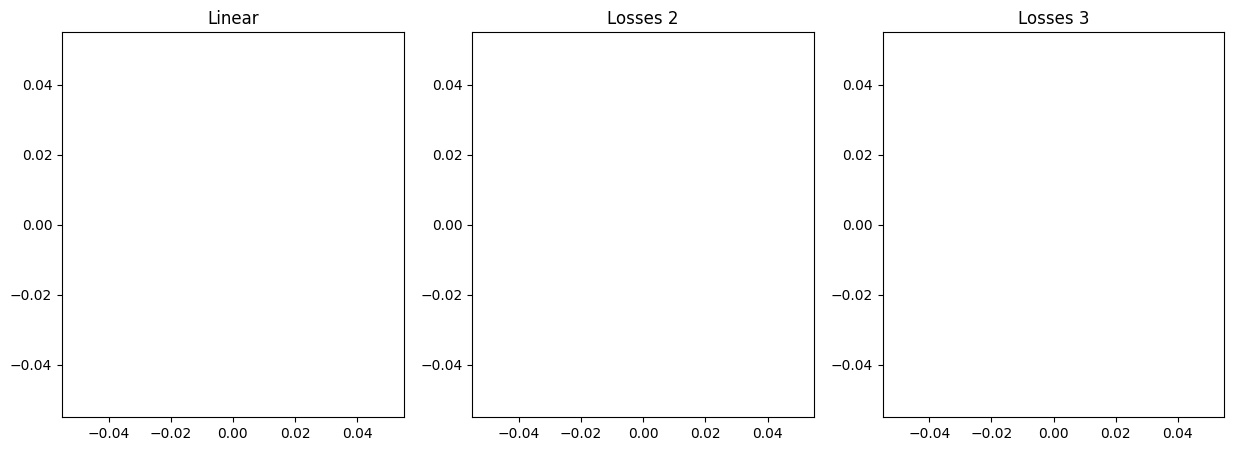

In [106]:
total_first_order_violations_linear_copy = np.array(total_first_order_violations_linear)
total_first_order_violations_cd_copy = np.array(total_first_order_violations_cd)
total_first_order_violations_leontief_copy = np.array(total_first_order_violations_leontief)

loss_linear_copy = loss_linear
loss_cd_copy = loss_cd
loss_leontief_copy = loss_leontief

total_first_order_violations_linear_copy = total_first_order_violations_linear_copy - 325
total_first_order_violations_cd_copy = total_first_order_violations_cd_copy
total_first_order_violations_leontief_copy = total_first_order_violations_leontief_copy


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(total_first_order_violations_linear_copy, label="Our Method")
axs[0].plot(loss_linear_copy, label="Neural Projection Method")
axs[0].set_title('Linear Economies')
axs[0].set_yscale('linear')

axs[1].plot(total_first_order_violations_cd_copy, label="Our Method")
axs[1].plot(loss_cd_copy, label="Neural Projection Method")
axs[1].set_title('Cobb-Douglas Economies')
axs[1].set_yscale('linear')

axs[2].plot(total_first_order_violations_leontief_copy, label="Our Method")
axs[2].plot(loss_leontief_copy, label="Neural Projection Method")
axs[2].set_title('Leontief economies')
axs[2].set_yscale('linear')

fig.suptitle('Comparison of Our Method and Neural Projection Method', fontsize=16, fontweight='bold')
fig.tight_layout()

plt.show()




In [108]:
total_first_order_violations_linear

[]